# Problem

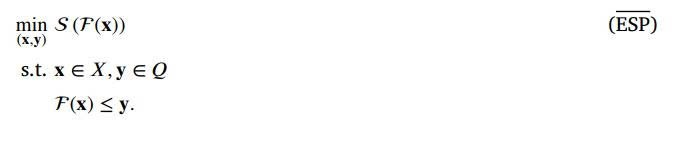

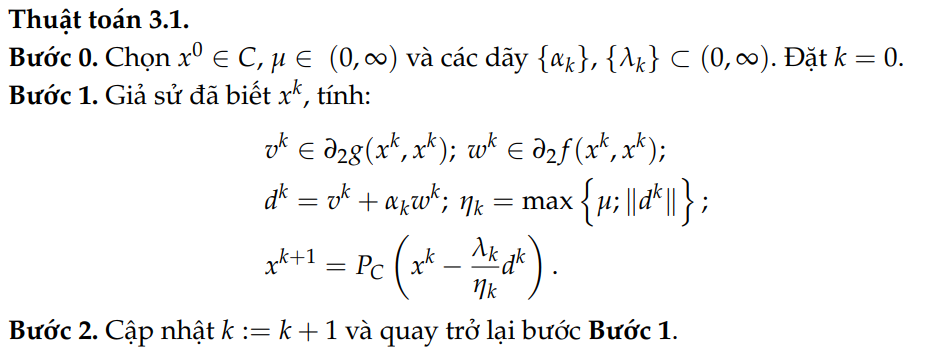

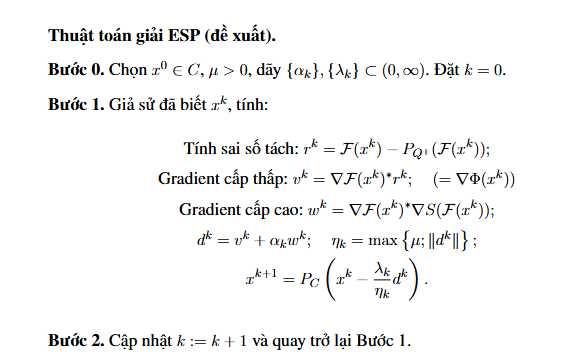

# Implement

In [6]:
import autograd.numpy as np
from autograd import jacobian
from scipy.optimize import Bounds
from project import Projection
from algorithm_CQ import CQ_split_acceptance
from problem import Problem
from prettytable import PrettyTable
from utils import visualize_complete_system
from utils import visualize_trajectory

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from prettytable import PrettyTable
import itertools
import pandas as pd

In [21]:
def optimize_phase2(prob, x_feasible, u_star, 
                    max_iter=1000, 
                    mu=0.1, 
                    expo_alpha=0.25,
                    expo_lambda=0.75,
                    init_params=1.0, 
                    verbose=True):
    """
    Giải bài toán ESP (đã chuyển về BO).
    
    Bài toán:
        Min S(F(x))  [tương ứng với việc tối thiểu khoảng cách tới u_star]
        s.t. x in argmin ||F(x) - P_Q+(F(x))||^2  [x thỏa mãn F(x) in Q+]
             x in C
    """
    
    # Khởi tạo
    x_curr = np.array(x_feasible).copy()
    path_x = [x_curr.copy()]
    
    # Lấy các hàm chiếu từ prob
    P_C = prob.proj_C
    P_Qplus = prob.proj_Qplus
    
    # Cấu hình bảng hiển thị
    if verbose:
        table = PrettyTable()
        table.field_names = ["k", "Alpha_k", "Step_len", "x_curr", "S(F(x))", "Gap Q+"]
        table.float_format = ".4"
        table.align = "r" 


    for k in range(max_iter):
        step = k + 1
        
        fx_curr = prob.objective_func(x_curr) # F(x)
        J = prob.jacobian(x_curr)             # J(x) = ∇F(x)

        # 2. Tính Gradient Cấp thấp (v^k) -> Giải quyết ràng buộc F(x) in Q+
        # r^k = F(x) - P_Q+(F(x))
        proj_q = P_Qplus(fx_curr)
        gap_vector = fx_curr - proj_q
        
        # v^k = J^T * (F(x) - P_Q+(F(x)))
        v_k = J.T @ gap_vector
        
        # 3. Tính Gradient Cấp cao (w^k) -> Tối ưu hóa hàm S
        grad_S = fx_curr - u_star
        
        # w^k = J^T * ∇ S(F(x))
        w_k = J.T @ grad_S
        
        # 4. Cập nhật tham số
        alpha_k = init_params / (step ** expo_alpha)
        lambda_k = init_params / (step ** expo_lambda)
        
        # 5. Tổng hợp hướng di chuyển d^k
        d_k = v_k + alpha_k * w_k
        
        # 6. Tính hệ số chuẩn hóa eta_k
        norm_d = np.linalg.norm(d_k)
        eta_k = max(mu, norm_d)
        
        # 7. Bước cập nhật và Chiếu lên C
        step_size = lambda_k / eta_k
        x_temp = x_curr - step_size * d_k
        x_next = P_C(x_temp)
        
        # --- Lưu và Log ---
        val_S = np.linalg.norm(fx_curr - u_star) 
        viol_q = np.linalg.norm(gap_vector)      
        
        if verbose:
            if k % 50 == 0 or k == max_iter - 1:
                x_str = np.array2string(x_curr, precision=3, separator=',')
                table.add_row([k, f"{alpha_k:.4f}", f"{step_size:.4f}", x_str, val_S, viol_q])
        
        path_x.append(x_next.copy())
        x_curr = x_next
        
        # Điều kiện dừng sớm (nếu cần)
        if norm_d < 1e-6 and viol_q < 1e-6:
            print(f"-> Thuật toán hội tụ sớm. Sau {k} vòng lặp")
            break

    if verbose:
        print(table)
        final_fx = prob.objective_func(x_curr)
        final_viol_q = np.linalg.norm(final_fx - P_Qplus(final_fx))
        print(f"-> Kết quả cuối cùng Phase 2: {x_curr}")
        print(f"-> S(F(x)): {np.linalg.norm(final_fx - u_star):.4f}")
        print(f"-> Sai số ràng buộc Q+ (Gap): {final_viol_q:.6f}")

    return x_curr, path_x

In [19]:
def visualize_trajectory_(path_x, prob, u_star, 
                         radius_c=2.0, 
                         q_bound=-1.0, 
                         x_limits=(-3.5, 2.5), 
                         y_limits=(-3.5, 1.5),
                         titles=None):
    """
    Hàm vẽ quỹ đạo tối ưu hóa trong không gian nguồn (C) và không gian ảnh (Q+).
    
    Tham số:
    - path_x: List hoặc array chứa lịch sử các điểm x qua từng bước lặp.
    - prob: Đối tượng bài toán (chứa phương thức objective_func).
    - u_star: Điểm mục tiêu mong muốn (trong không gian ảnh).
    - radius_c: Bán kính của tập ràng buộc C (mặc định 2.0).
    - q_bound: Giới hạn trên của tập Q+ (mặc định -1.0 cho cả 2 chiều).
    - x_limits: Tuple (min, max) cho trục của đồ thị X.
    - y_limits: Tuple (min, max) cho trục của đồ thị Y.
    - titles: Tuple hoặc List chứa 2 chuỗi ký tự (Title_X, Title_Y). 
              Ví dụ: ("Không gian biến", "Không gian ảnh").
              Nếu None, sẽ dùng title mặc định.
    """
    
    # 1. Chuẩn bị dữ liệu quỹ đạo
    path_x_arr = np.array(path_x) 
    
    # Tính toán quỹ đạo f(x) tương ứng
    path_f_arr = np.array([prob.objective_func(p) for p in path_x_arr])

    # 2. TÍNH TOÁN BIÊN CỦA f(C)
    # Tạo các điểm trên biên của C (Hình tròn) để ánh xạ sang bên phải
    theta = np.linspace(0, 2*np.pi, 200) # 200 điểm cho mượt
    boundary_x = radius_c * np.cos(theta)
    boundary_y = radius_c * np.sin(theta)
    boundary_C_points = np.vstack((boundary_x, boundary_y)).T

    # Ánh xạ các điểm biên này qua hàm f để có biên của f(C)
    boundary_fC_points = np.array([prob.objective_func(p) for p in boundary_C_points])

    # 3. Khởi tạo khung hình
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # --- XỬ LÝ TIÊU ĐỀ (TITLES) ---
    title_x = "Không gian biến $X$" # Mặc định
    title_y = "Không gian ảnh $Y$"  # Mặc định
    
    if titles is not None:
        if len(titles) >= 1: title_x = titles[0]
        if len(titles) >= 2: title_y = titles[1]

    # =========================================================
    # HÌNH 1: KHÔNG GIAN BIẾN X (Tập C và quỹ đạo x)
    # =========================================================
    ax1.set_title(title_x, fontsize=14) # <--- SỬ DỤNG TITLE X

    # Vẽ Tập C (Hình tròn)
    circle = plt.Circle((0, 0), radius_c, color='skyblue', alpha=0.3, label='Miền C')
    ax1.add_patch(circle)
    ax1.add_patch(plt.Circle((0, 0), radius_c, color='blue', fill=False, linestyle='--')) # Viền

    # Vẽ quỹ đạo x
    ax1.plot(path_x_arr[:, 0], path_x_arr[:, 1], 'k.-', linewidth=1.5, label='Quỹ đạo $x$')
    ax1.scatter(path_x_arr[0, 0], path_x_arr[0, 1], c='cyan', s=100, edgecolors='k', label='Start')
    ax1.scatter(path_x_arr[-1, 0], path_x_arr[-1, 1], c='red', s=120, marker='X', edgecolors='k', label='Final $x$')

    # Trang trí Ax1
    ax1.set_xlim(x_limits[0], x_limits[1])
    ax1.set_ylim(x_limits[0], x_limits[1]) 
    ax1.set_aspect('equal')
    ax1.grid(True, linestyle=':', alpha=0.6)
    ax1.set_xlabel("$x_1$")
    ax1.set_ylabel("$x_2$")
    ax1.legend(loc='upper right')

    # =========================================================
    # HÌNH 2: KHÔNG GIAN ẢNH Y (Ảnh f(C), Q+ và quỹ đạo f(x))
    # =========================================================
    ax2.set_title(title_y, fontsize=14) # <--- SỬ DỤNG TITLE Y

    # Vẽ Tập Ảnh f(C) dùng Polygon
    poly_fC = plt.Polygon(boundary_fC_points, closed=True, facecolor='mediumpurple', alpha=0.4, label='Ảnh $f(C)$')
    ax2.add_patch(poly_fC)
    # Vẽ đường viền của f(C)
    ax2.plot(boundary_fC_points[:, 0], boundary_fC_points[:, 1], color='indigo', linestyle='--', linewidth=1)

    # Vẽ biên giới hạn của Q+
    ax2.axvline(x=q_bound, color='red', linestyle='--', linewidth=1.5, label=f'Biên $Q^+$')
    ax2.axhline(y=q_bound, color='red', linestyle='--', linewidth=1.5)

    # Tô màu vùng Q+ (Vùng khả thi của f(x))
    rect_width = abs(y_limits[0] - q_bound) + 5 
    rect_height = abs(y_limits[0] - q_bound) + 5
    rect_Qplus = patches.Rectangle((q_bound - rect_width, q_bound - rect_height), 
                                   rect_width, rect_height, 
                                   color='salmon', alpha=0.1, label='Miền $Q^+$')
    ax2.add_patch(rect_Qplus)

    # Vẽ điểm mục tiêu u* (Target)
    ax2.scatter(u_star[0], u_star[1], c='gold', s=300, marker='*', edgecolors='k', zorder=10, label='Target $u^*$')

    # Vẽ quỹ đạo f(x)
    ax2.plot(path_f_arr[:, 0], path_f_arr[:, 1], 'k.-', linewidth=1.5, label='Quỹ đạo $f(x)$')
    ax2.scatter(path_f_arr[-1, 0], path_f_arr[-1, 1], c='red', s=120, marker='X', edgecolors='k', label='Final $f(x)$')

    # Trang trí Ax2
    ax2.set_xlim(y_limits[0], y_limits[1])
    ax2.set_ylim(y_limits[0], y_limits[1])
    ax2.set_aspect('equal')
    ax2.grid(True, linestyle=':', alpha=0.6)
    ax2.set_xlabel("$f_1(x)$")
    ax2.set_ylabel("$f_2(x)$")
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Define

In [9]:
# ==========================================
# 1. ĐỊNH NGHĨA BÀI TOÁN CỤ THỂ
# ==========================================

# Hàm f(x) = x
def f(x):
    return np.array([x[0], x[1]])

def jac_f_func(x):
    return np.eye(2)

# --- Tập C: Hình tròn tâm O, bán kính 2 ---
# x1^2 + x2^2 <= 4
def c1(x):
    return 4 - (x[0]**2 + x[1]**2)

cons_C = ({'type': 'ineq', 'fun': c1},)
bounds_x = None 
dim_x = 2

# --- Tập Q: Hình hộp [-3, -1] x [-3, -1] ---
def q_box_lower(y): return np.array([y[0] + 3, y[1] + 3])
def q_box_upper(y): return np.array([-1 - y[0], -1 - y[1]])
def q_plus_upper(t):
    return np.array([-1 - t[0], -1 - t[1]])



# Hàm dùng cho Projection Qplus (chỉ cần chặn trên của Q để xác định Q+)
# Q+ = {z | z <= y_max}, ở đây y_max = (-1, -1)
cons_Q = (
    {'type': 'ineq', 'fun': lambda y: np.concatenate([q_box_lower(y), q_box_upper(y)])},
)

cons_Qplus = (
    {'type': 'ineq', 'fun': q_plus_upper},
)
dim_y = 2

# Phase 1

In [10]:
# ==========================================
# 2. KHỞI TẠO ĐỐI TƯỢNG VÀ GIẢI CẤP 1
# ==========================================

print("=== BẮT ĐẦU VÍ DỤ MINH HỌA ESP 2 CẤP ===")

# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')

# Setup Problem
prob = Problem(
    f=[f], jac_f=[jac_f_func], C=[c1], Q=[], 
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)

# --- Điểm khởi tạo Phase 1 ---
x_init = np.array([2.0, 2.0]) # Trong C, nhưng vi phạm Q+

print("\n--- PHASE 1: TÌM ĐIỂM KHẢ THI (CQ ALGORITHM) ---")
# Chạy thuật toán CQ có sẵn của bạn
x_feasible, x_hist, f_hist, z_proj_hist = CQ_split_acceptance(
    f=prob.objective_func,
    jac_f=prob.jacobian,
    proj_C=prob.proj_C,
    proj_Qplus=prob.proj_Qplus,
    x0=x_init,
    gamma=0.5, # Learning rate cho CQ
    max_iter=50,
    tol=1e-4
)

print(f"-> Điểm khả thi tìm được sau Phase 1: {x_feasible}")

=== BẮT ĐẦU VÍ DỤ MINH HỌA ESP 2 CẤP ===

--- PHASE 1: TÌM ĐIỂM KHẢ THI (CQ ALGORITHM) ---
Khởi tạo: x0: [2. 2.]
Chiếu lên C được: x: [1.4142 1.4142]


 30%|███       | 15/50 [00:00<00:00, 291.26it/s]


Hội tụ tại vòng lặp 15
+----+------------------------+---------+------------------------+------------+----------+----------+
| k  | x_new                  | gamma_k | y                      | z_proj     |   e_x    |   e_f    |
+----+------------------------+---------+------------------------+------------+----------+----------+
| 0  | [1.414201, 1.414227]   | 0.5000  | [1.414201, 1.414227]   | [-1., -1.] | 1.707111 | 3.414214 |
| 1  | [0.207097, 0.207111]   | 0.5000  | [0.207097, 0.207111]   | [-1., -1.] | 0.853547 | 1.707103 |
| 2  | [-0.396448, -0.396442] | 0.5000  | [-0.396448, -0.396442] | [-1., -1.] | 0.426779 | 0.853556 |
| 3  | [-0.698223, -0.698223] | 0.5000  | [-0.698223, -0.698223] | [-1., -1.] | 0.213388 | 0.426777 |
| 4  | [-0.849112, -0.849111] | 0.5000  | [-0.849112, -0.849111] | [-1., -1.] | 0.106694 | 0.213389 |
| 5  | [-0.924556, -0.924555] | 0.5000  | [-0.924556, -0.924555] | [-1., -1.] | 0.053346 | 0.106695 |
| 6  | [-0.962274, -0.962279] | 0.5000  | [-0.962274, -0.9

Đang xử lý dữ liệu và tạo đồ thị tổng hợp...


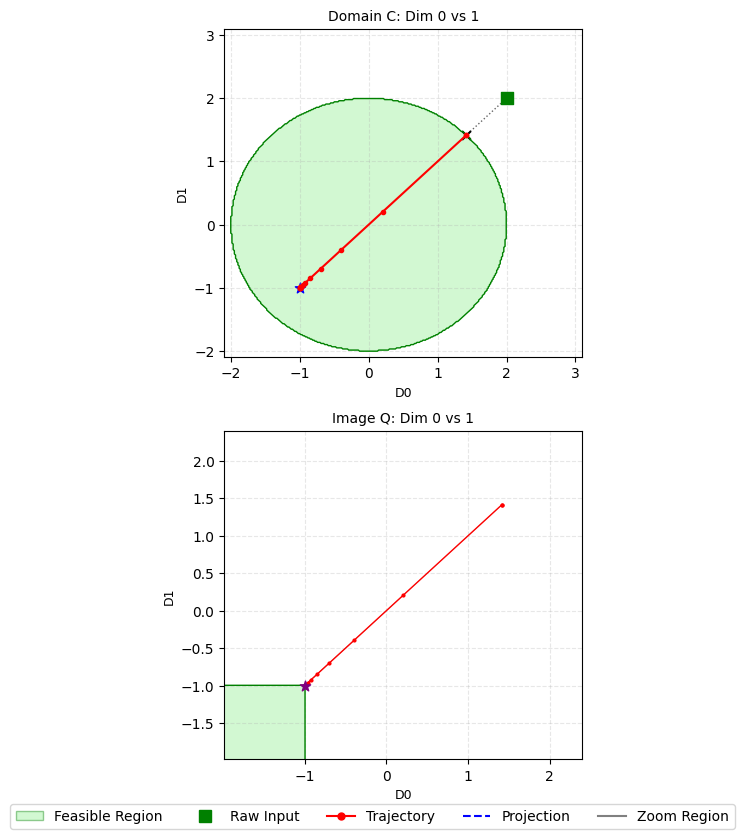

In [11]:
_ = visualize_complete_system(
    x_hist, f_hist, z_proj_hist,
    cons_C, cons_Qplus,
    x0=x_init,   
)

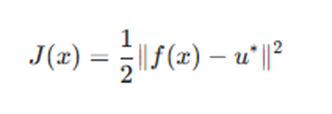

Tìm $x \in C $ sao cho $L(x) = \frac{1}{2} \lVert f(x) - u^* \lVert^2$ đạt min

* Điểm khởi tạo: $x_t, y_t = f(x_t), J_t = J(x_t)$

* $\nabla f$: $w_k = J^T . (y_t - u^*)$
* $\nabla g$: $v_k$
    * $grad_Q = J^T . (y_t - P_{Q^+}(y_t))$
    * $v_k = grad_Q$

* $d_k = \alpha_k * w_k + v_k$

* $
\boxed{
x_{k+1} = x_k - \frac{\lambda_k}{\eta_k} d_k
}
$


trong đó:  
* $\alpha_k = \frac{1}{k^{0.25}}$
* $\lambda_k = \frac{1}{k^{0.75}}$
* $\eta_k = max\{0.1, \lVert d_k \lVert\}$

# Test

In [12]:
u_star = np.array([-0.5, -1.5])
expo_alpha = 0.25
expo_lambda = 0.75
init_params = 1.0

In [13]:
x_final, path_x = optimize_phase2(
    prob=prob,
    x_feasible=x_feasible,  
    u_star=u_star, 
    max_iter=1000,
    mu=0.1,
    expo_alpha=expo_alpha,
    expo_lambda=expo_lambda,
    init_params=init_params,
    verbose=True
)


--- BẮT ĐẦU PHASE 2: Tối ưu hóa trên tập nghiệm hữu hiệu ---
+-----+---------+----------+-----------------+---------+--------+
|   k | Alpha_k | Step_len |          x_curr | S(F(x)) | Gap Q+ |
+-----+---------+----------+-----------------+---------+--------+
|   0 |  1.0000 |   1.4142 |       [-1.,-1.] |  0.7071 | 0.0001 |
|  50 |  0.3742 |   0.5240 | [-0.863,-1.5  ] |  0.3632 | 0.1368 |
| 100 |  0.3154 |   0.3139 |   [-0.88,-1.5 ] |  0.3796 | 0.1204 |
| 150 |  0.2853 |   0.2321 | [-0.889,-1.5  ] |  0.3885 | 0.1115 |
| 200 |  0.2656 |   0.1873 | [-0.895,-1.5  ] |  0.3946 | 0.1054 |
| 250 |  0.2512 |   0.1586 | [-0.899,-1.5  ] |  0.3992 | 0.1008 |
| 300 |  0.2401 |   0.1384 | [-0.903,-1.5  ] |  0.4028 | 0.0972 |
| 350 |  0.2310 |   0.1233 | [-0.906,-1.5  ] |  0.4058 | 0.0942 |
| 400 |  0.2235 |   0.1116 | [-0.908,-1.5  ] |  0.4083 | 0.0917 |
| 450 |  0.2170 |   0.1022 |   [-0.91,-1.5 ] |  0.4105 | 0.0895 |
| 500 |  0.2114 |   0.0944 | [-0.912,-1.5  ] |  0.4124 | 0.0876 |
| 550 |  0.206

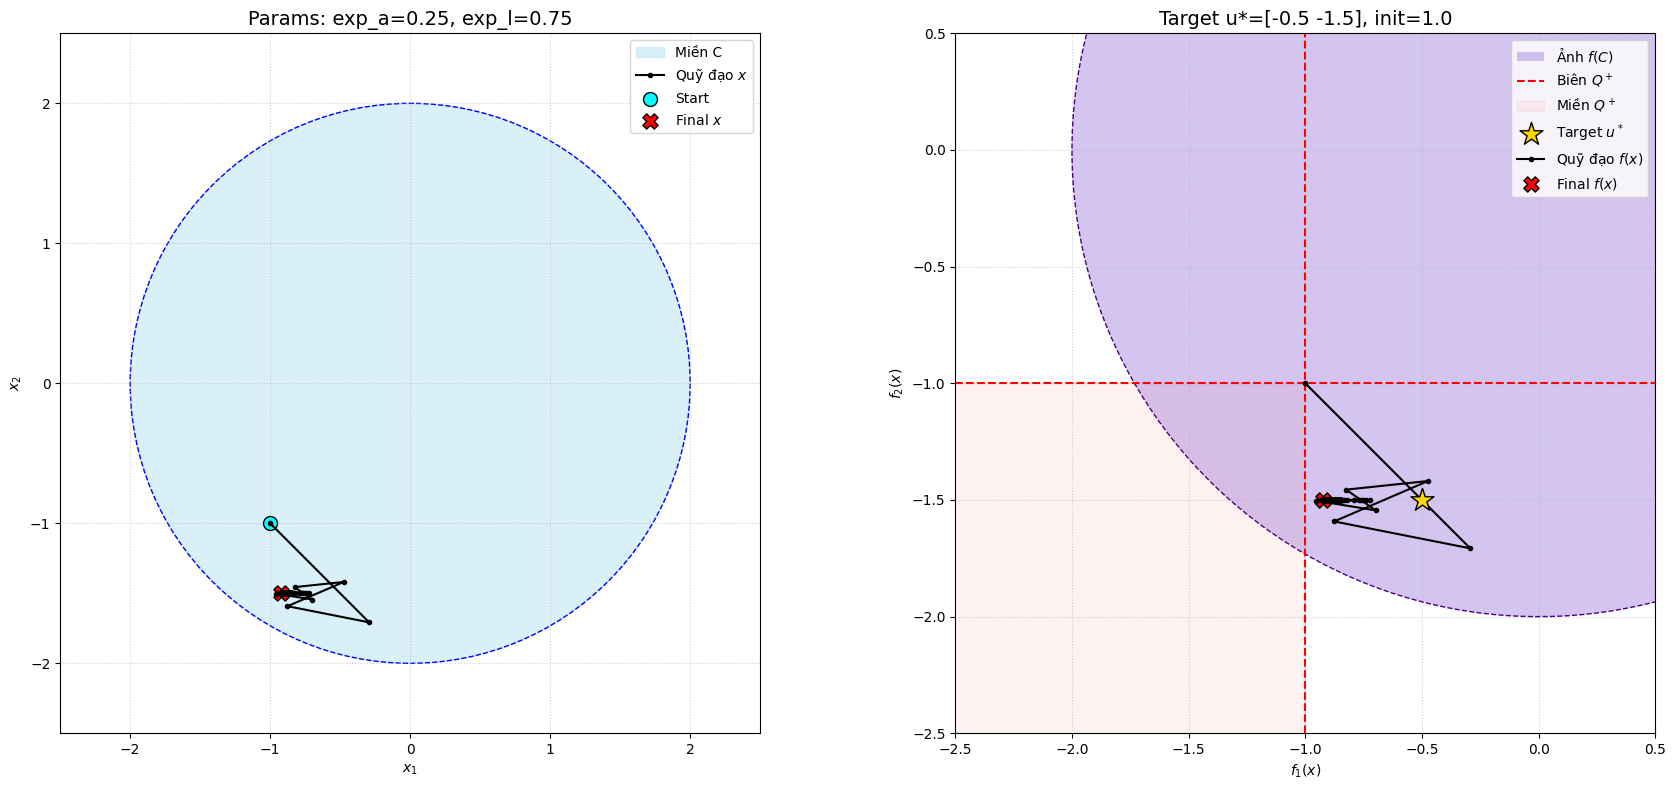

In [14]:
visualize_trajectory_(
    path_x=path_x,      
    prob=prob,           
    u_star=u_star,      
    radius_c=2.0,       
    q_bound=-1.0,       
    x_limits=(-2.5, 2.5), 
    y_limits=(-2.5, 0.5),
    titles=(
        f"Params: exp_a={expo_alpha}, exp_l={expo_lambda}", 
        f"Target u*={u_star}, init={init_params}"     
    )
)

# Run all

In [22]:
def run_experiment_grid(prob, x_feasible, 
                        list_u_star, 
                        list_expo_alpha, 
                        list_expo_lambda, 
                        list_init_params,
                        max_iter=1000):
    
    # Tạo tất cả các tổ hợp tham số (Cartesian product)
    combinations = list(itertools.product(list_u_star, list_expo_alpha, list_expo_lambda, list_init_params))
    
    print(f"=== TỔNG SỐ THÍ NGHIỆM CẦN CHẠY: {len(combinations)} ===")
    
    summary_data = []
    
    for i, (u_star, exp_a, exp_l, init_p) in enumerate(combinations):
        exp_id = i + 1
        print(f"\n{'='*60}")
        print(f"EXPERIMENT #{exp_id}/{len(combinations)}")
        print(f"Config: u*={u_star}, exp_a={exp_a}, exp_l={exp_l}, init={init_p}")
        print(f"{'='*60}")
        
        # 1. Chạy tối ưu
        x_final, path_x = optimize_phase2(
            prob=prob,
            x_feasible=x_feasible,
            u_star=u_star,
            max_iter=max_iter,
            mu=0.1,
            init_params=init_p,
            expo_alpha=exp_a,   # Truyền tham số động
            expo_lambda=exp_l,  # Truyền tham số động
            verbose=False       # Tắt verbose chi tiết để đỡ rối
        )
        
        # 2. Tính toán kết quả cuối
        final_f = prob.objective_func(x_final)
        dist_u = np.linalg.norm(final_f - u_star)
        
        # Tính vi phạm ràng buộc cuối cùng
        proj_q = prob.proj_Qplus(final_f)
        viol_q = np.linalg.norm(final_f - proj_q)
        proj_c = prob.proj_C(x_final)
        viol_c = np.linalg.norm(x_final - proj_c)
        
        # Lưu vào bảng tổng kết
        summary_data.append({
            "ID": exp_id,
            "u*": str(u_star),
            "Exp_Alpha": exp_a,
            "Exp_Lambda": exp_l,
            "Init_P": init_p,
            "Final_Dist_u*": round(dist_u, 5),
            "Viol_Q+": round(viol_q, 5),
            "Viol_C": round(viol_c, 5)
        })
        
        # 3. Vẽ đồ thị
        # Tạo title động cho từng hình
        title_left = f"Exp #{exp_id}: Params(a={exp_a}, l={exp_l})"
        title_right = f"Target {u_star} | Init {init_p} | Dist: {dist_u:.3f}"
        
        visualize_trajectory_(
            path_x=path_x,      
            prob=prob,           
            u_star=u_star,      
            radius_c=2.0,       
            q_bound=-1.0,       
            x_limits=(-2.5, 2.5), 
            y_limits=(-2.5, 0.5), # Căn chỉnh lại cho hợp lý với u*
            titles=(title_left, title_right)
        )
        
    # 4. Hiển thị bảng tổng kết sau khi chạy xong hết
    print("\n\n" + "="*30 + " KẾT QUẢ TỔNG HỢP " + "="*30)
    df_results = pd.DataFrame(summary_data)
    
    # Hiển thị đẹp bằng PrettyTable nếu không dùng Jupyter Notebook, 
    # hoặc print dataframe nếu dùng Jupyter
    if len(summary_data) > 0:
        summary_table = PrettyTable()
        summary_table.field_names = df_results.columns.tolist()
        for row in df_results.itertuples(index=False):
            summary_table.add_row(row)
        print(summary_table)
        
    return df_results

=== TỔNG SỐ THÍ NGHIỆM CẦN CHẠY: 24 ===

EXPERIMENT #1/24
Config: u*=[-1.25 -1.25], exp_a=0.4, exp_l=0.6, init=0.75
-> Thuật toán hội tụ sớm. Sau 11 vòng lặp


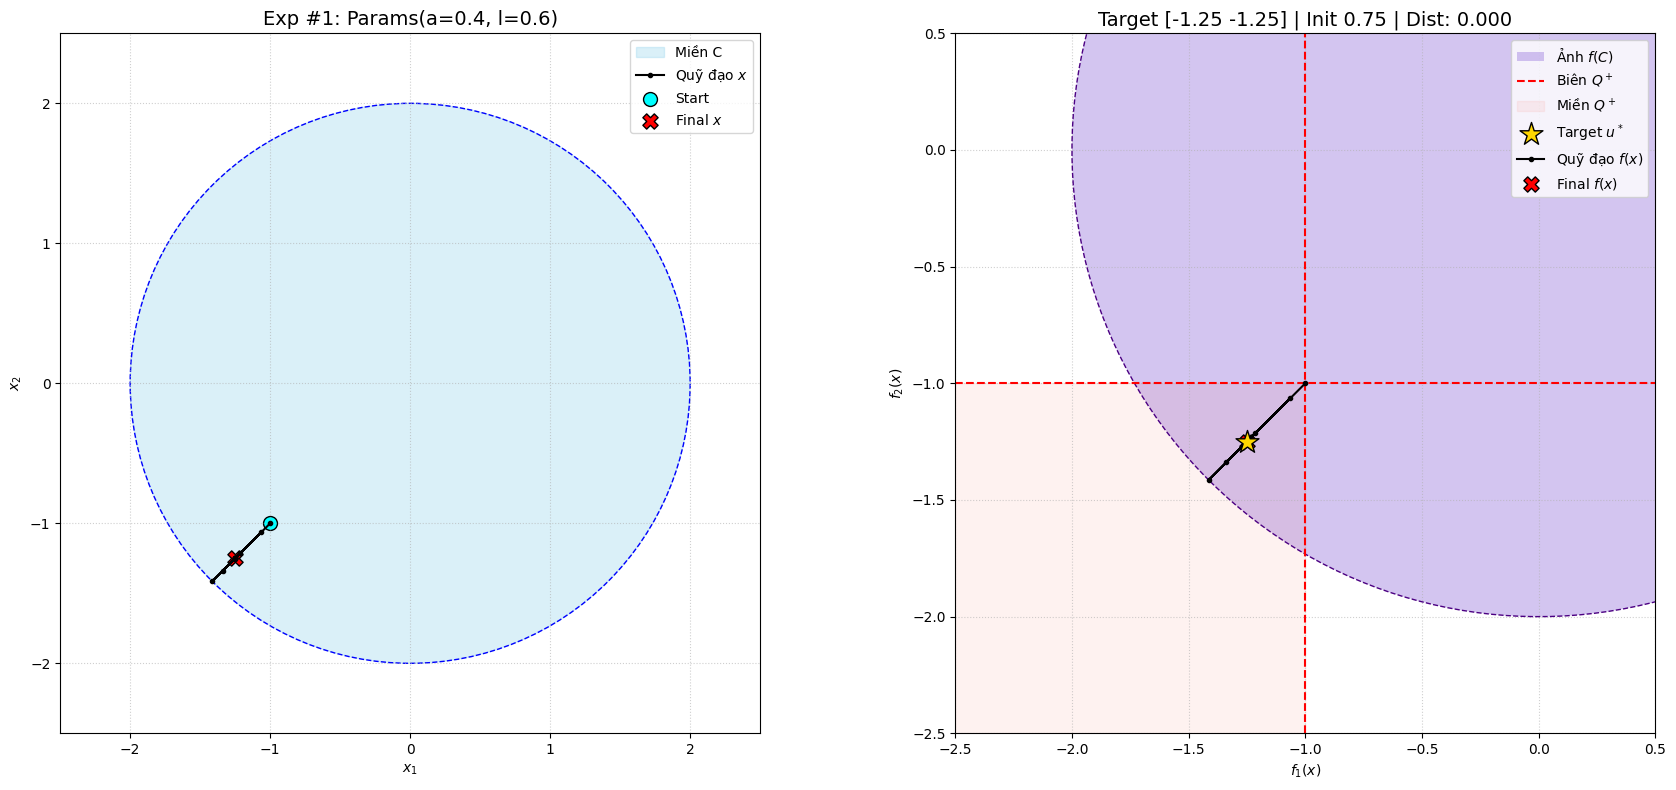


EXPERIMENT #2/24
Config: u*=[-1.25 -1.25], exp_a=0.4, exp_l=0.6, init=0.35
-> Thuật toán hội tụ sớm. Sau 48 vòng lặp


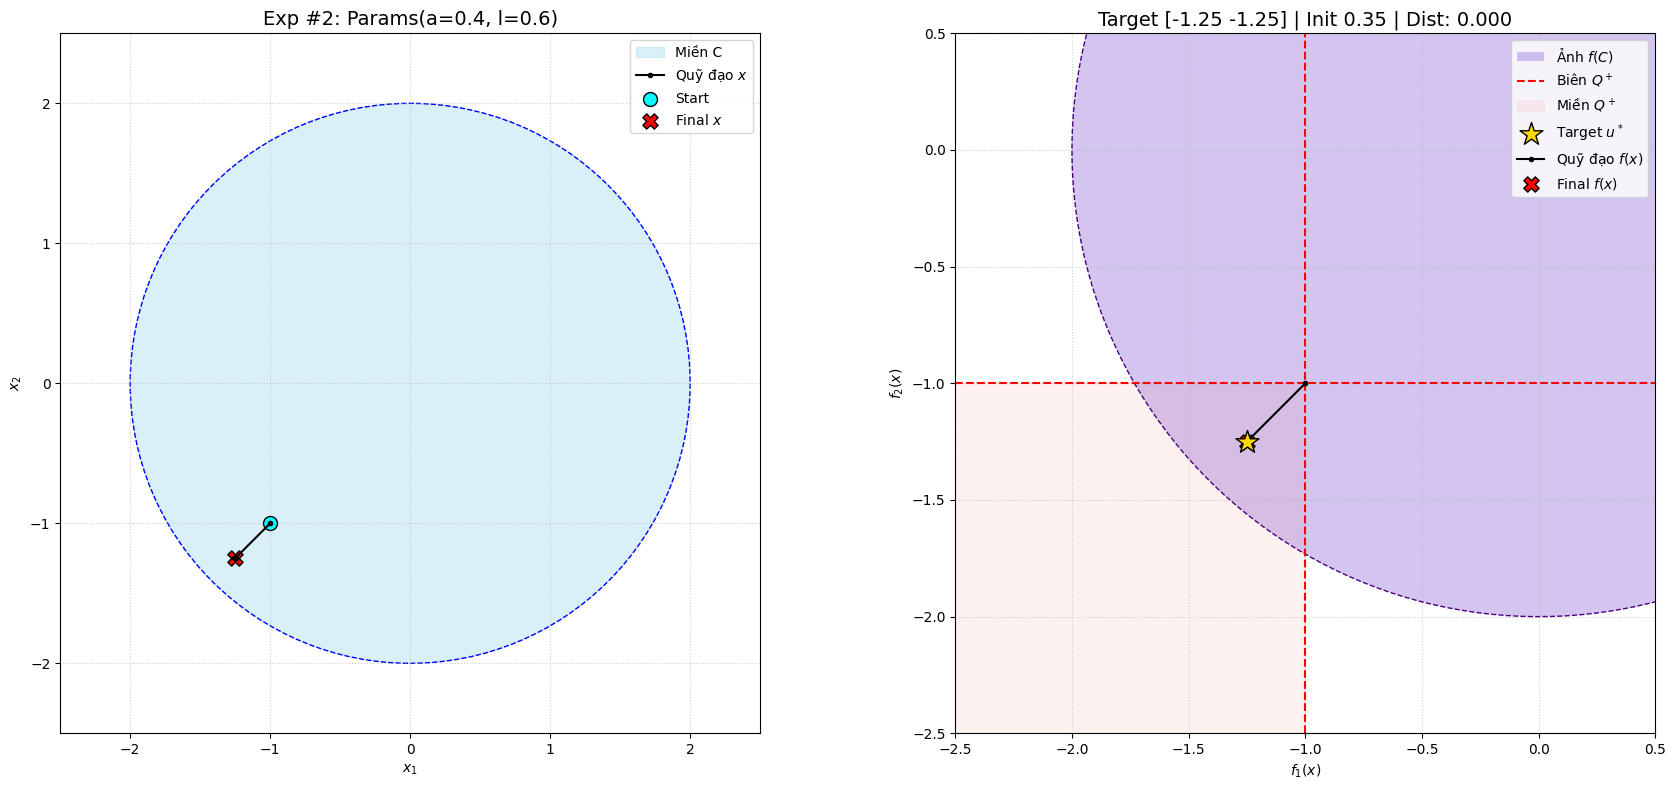


EXPERIMENT #3/24
Config: u*=[-1.25 -1.25], exp_a=0.4, exp_l=0.8, init=0.75
-> Thuật toán hội tụ sớm. Sau 21 vòng lặp


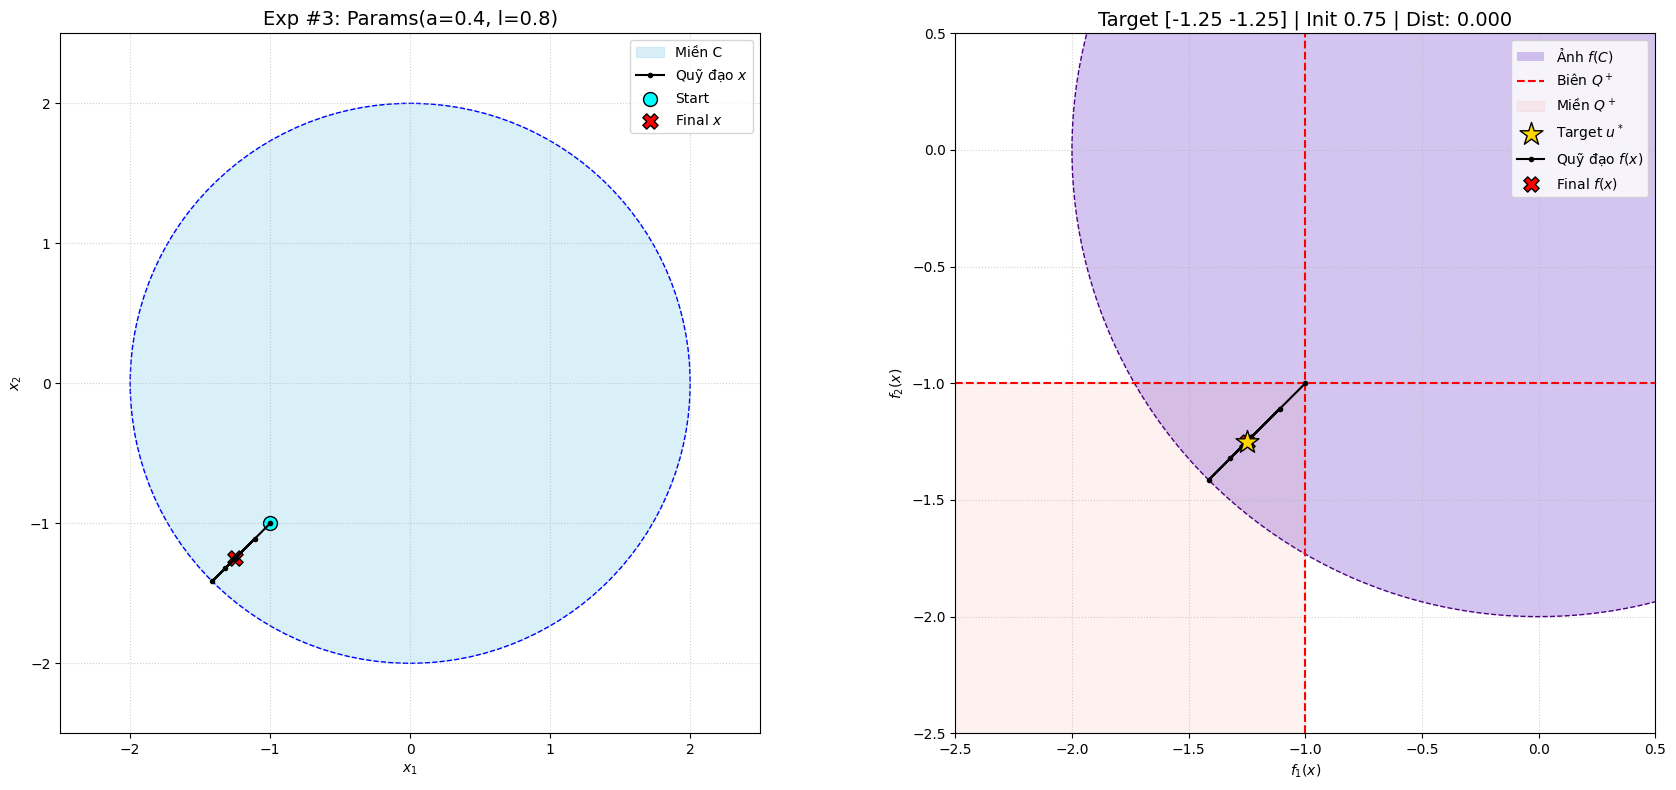


EXPERIMENT #4/24
Config: u*=[-1.25 -1.25], exp_a=0.4, exp_l=0.8, init=0.35
-> Thuật toán hội tụ sớm. Sau 377 vòng lặp


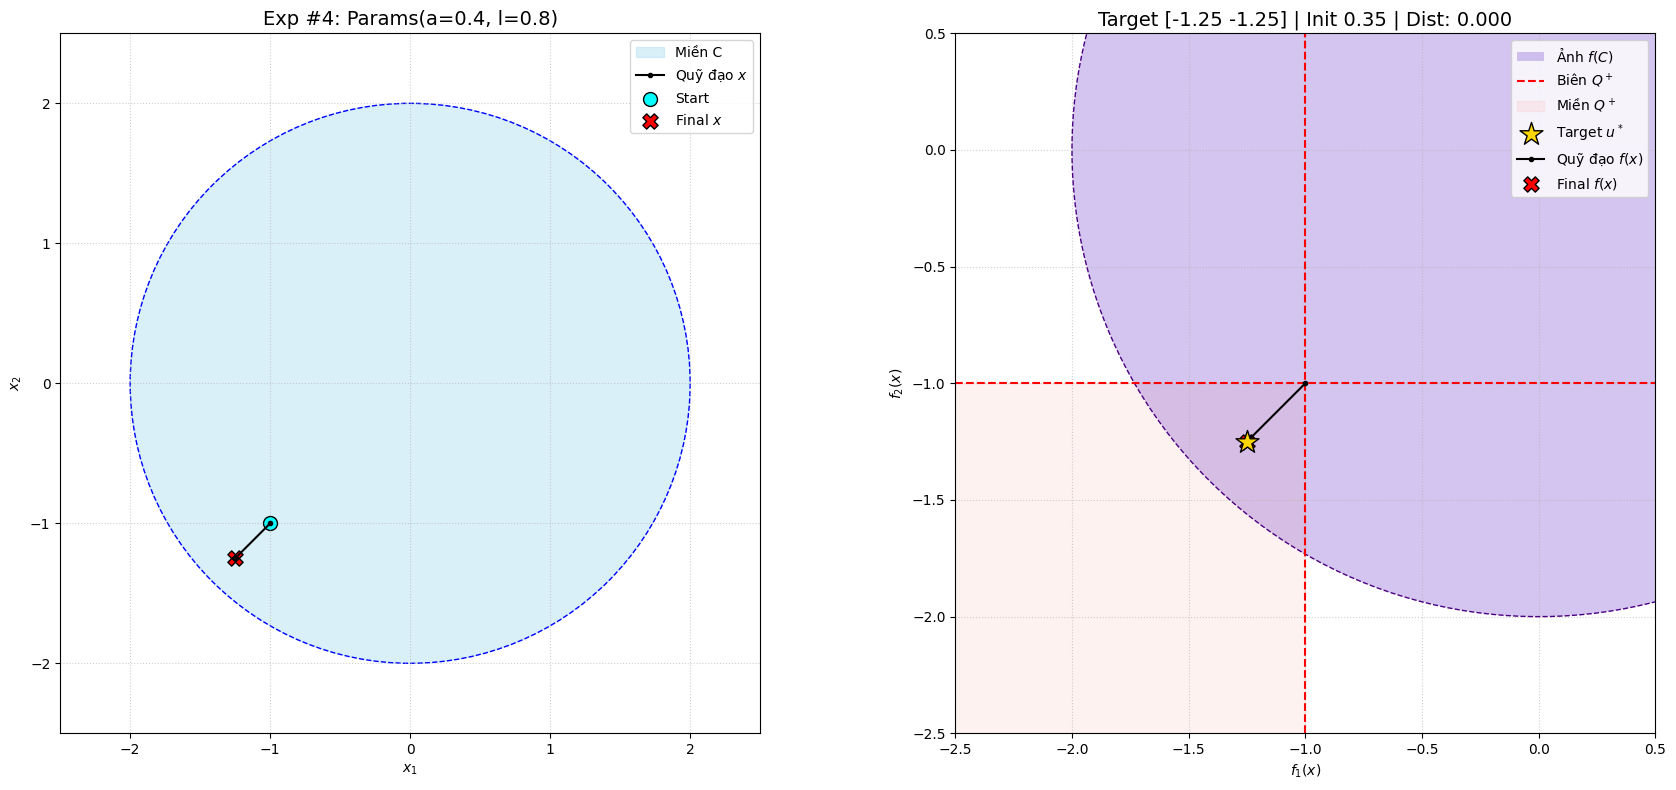


EXPERIMENT #5/24
Config: u*=[-1.25 -1.25], exp_a=0.6, exp_l=0.6, init=0.75
-> Thuật toán hội tụ sớm. Sau 75 vòng lặp


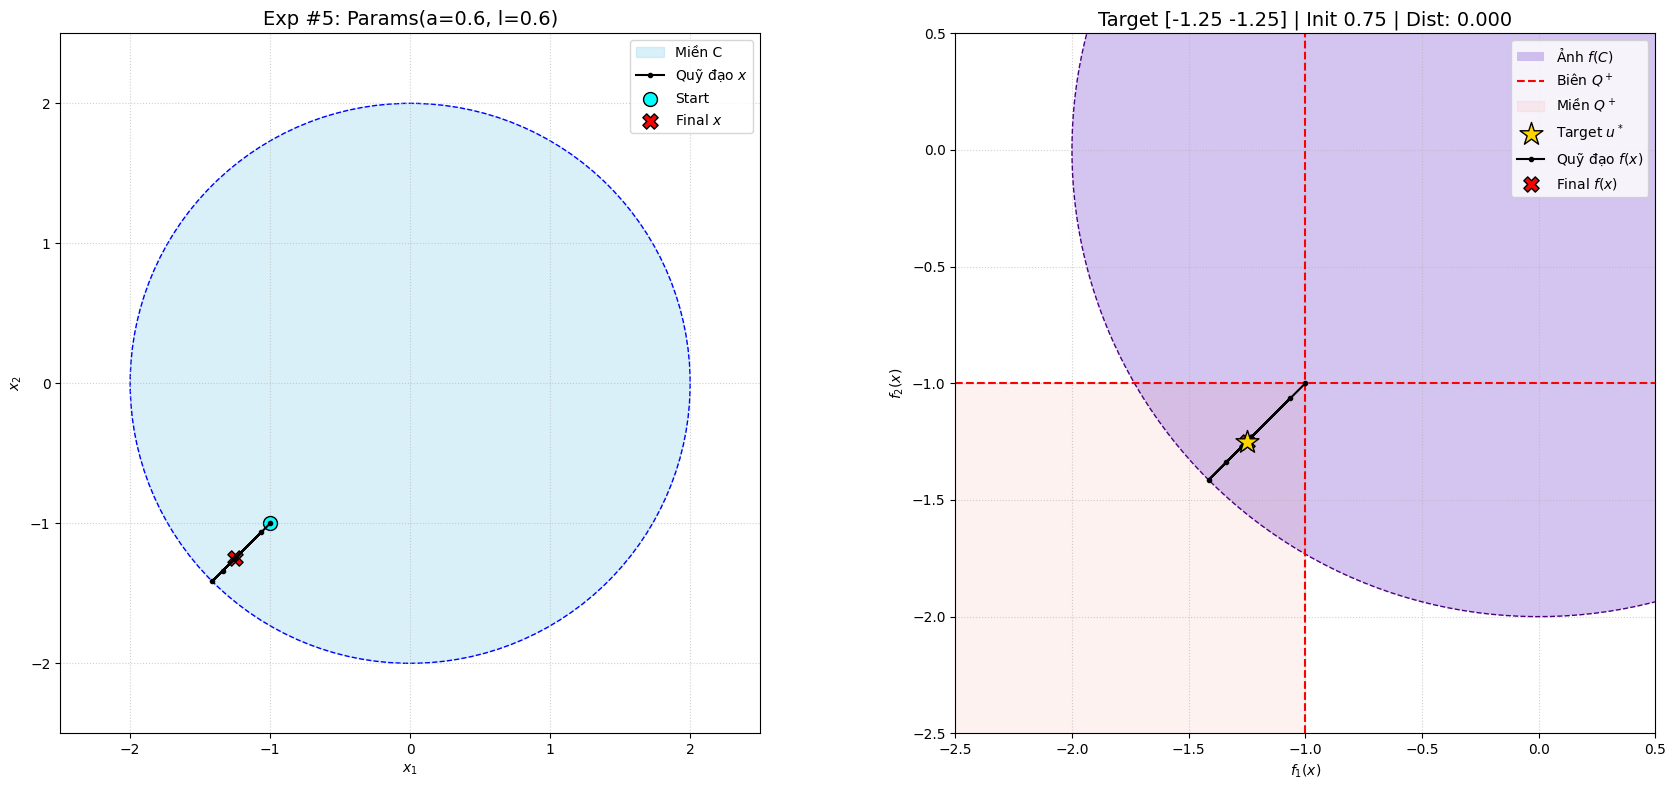


EXPERIMENT #6/24
Config: u*=[-1.25 -1.25], exp_a=0.6, exp_l=0.6, init=0.35
-> Thuật toán hội tụ sớm. Sau 416 vòng lặp


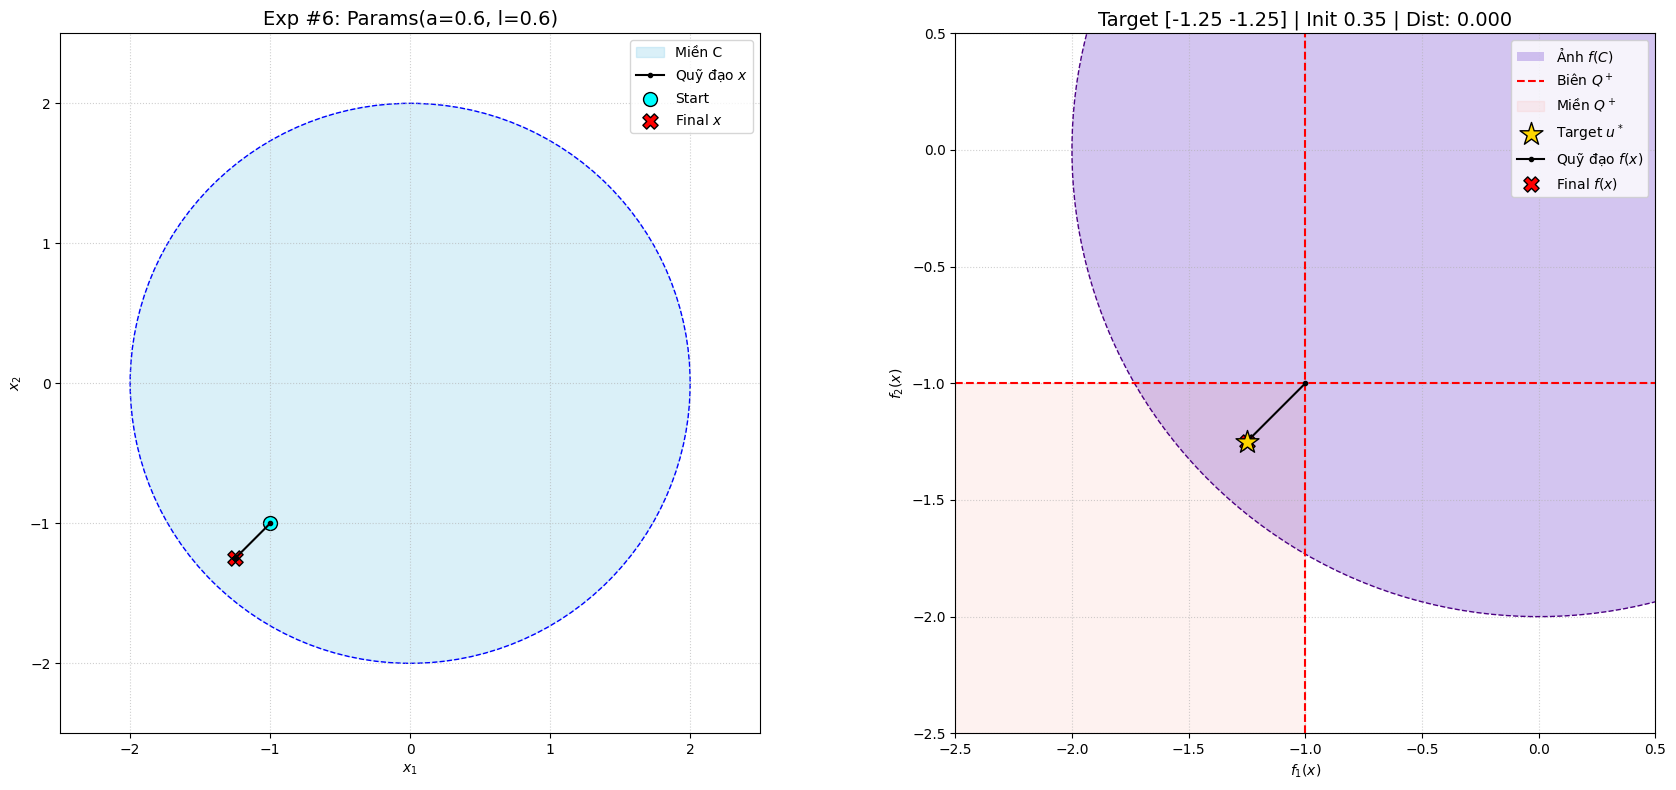


EXPERIMENT #7/24
Config: u*=[-1.25 -1.25], exp_a=0.6, exp_l=0.8, init=0.75


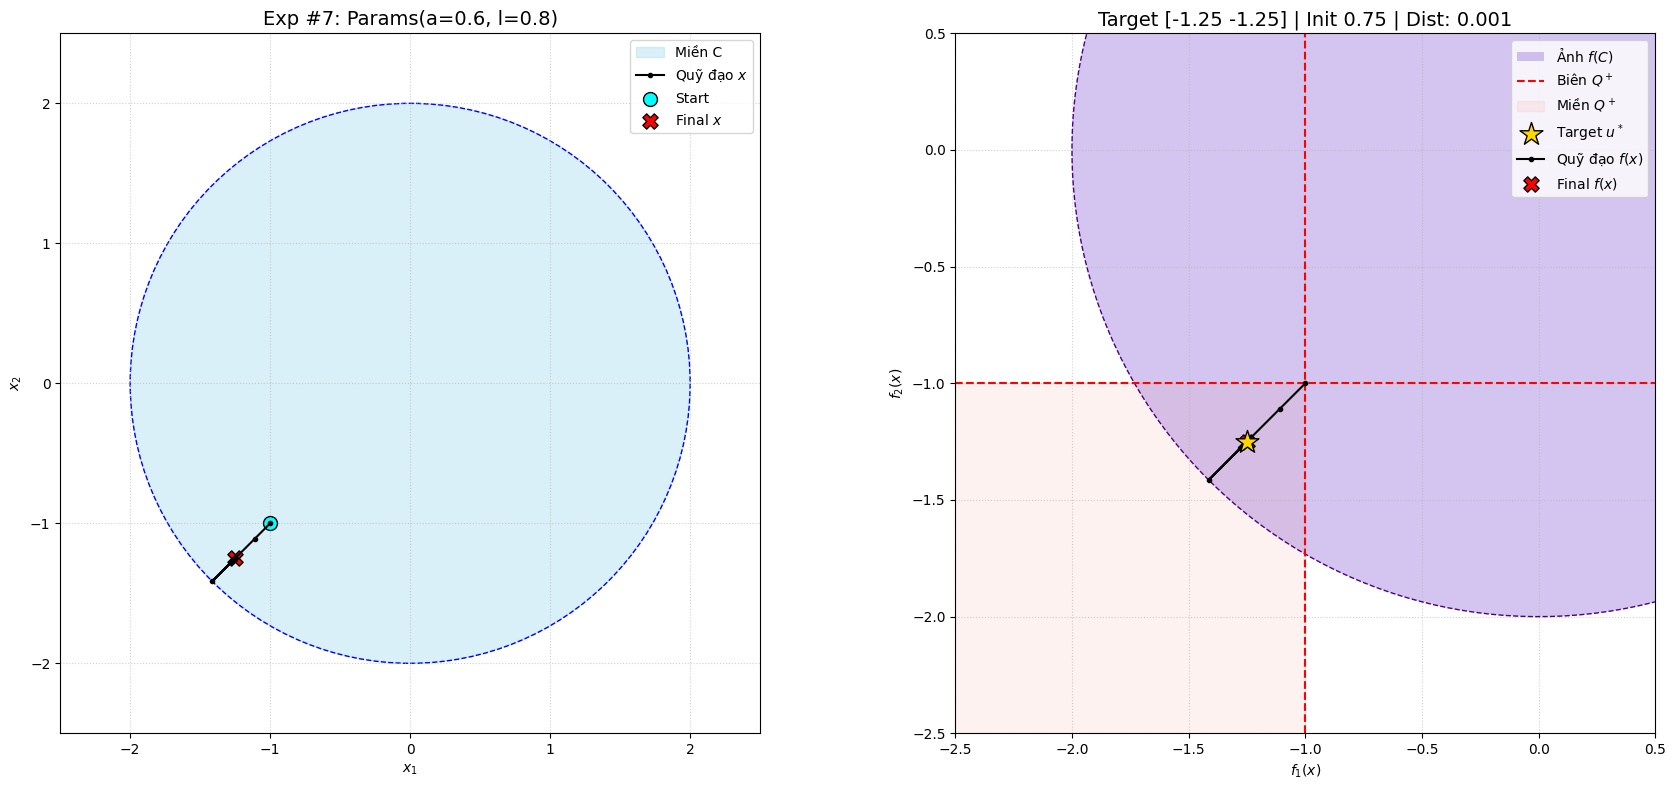


EXPERIMENT #8/24
Config: u*=[-1.25 -1.25], exp_a=0.6, exp_l=0.8, init=0.35
-> Thuật toán hội tụ sớm. Sau 299 vòng lặp


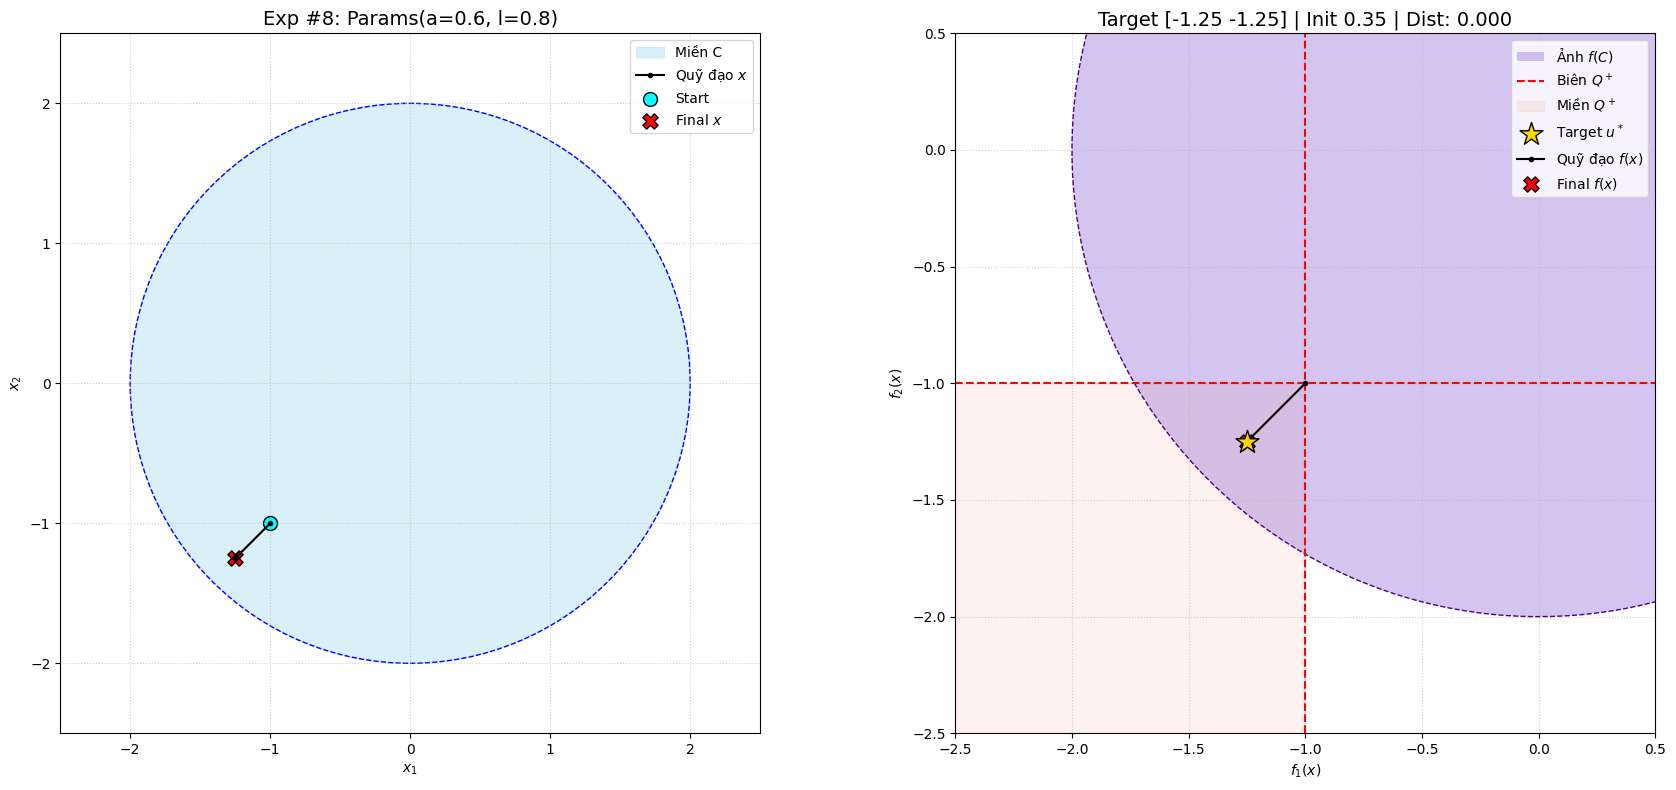


EXPERIMENT #9/24
Config: u*=[-0.5 -1.5], exp_a=0.4, exp_l=0.6, init=0.75


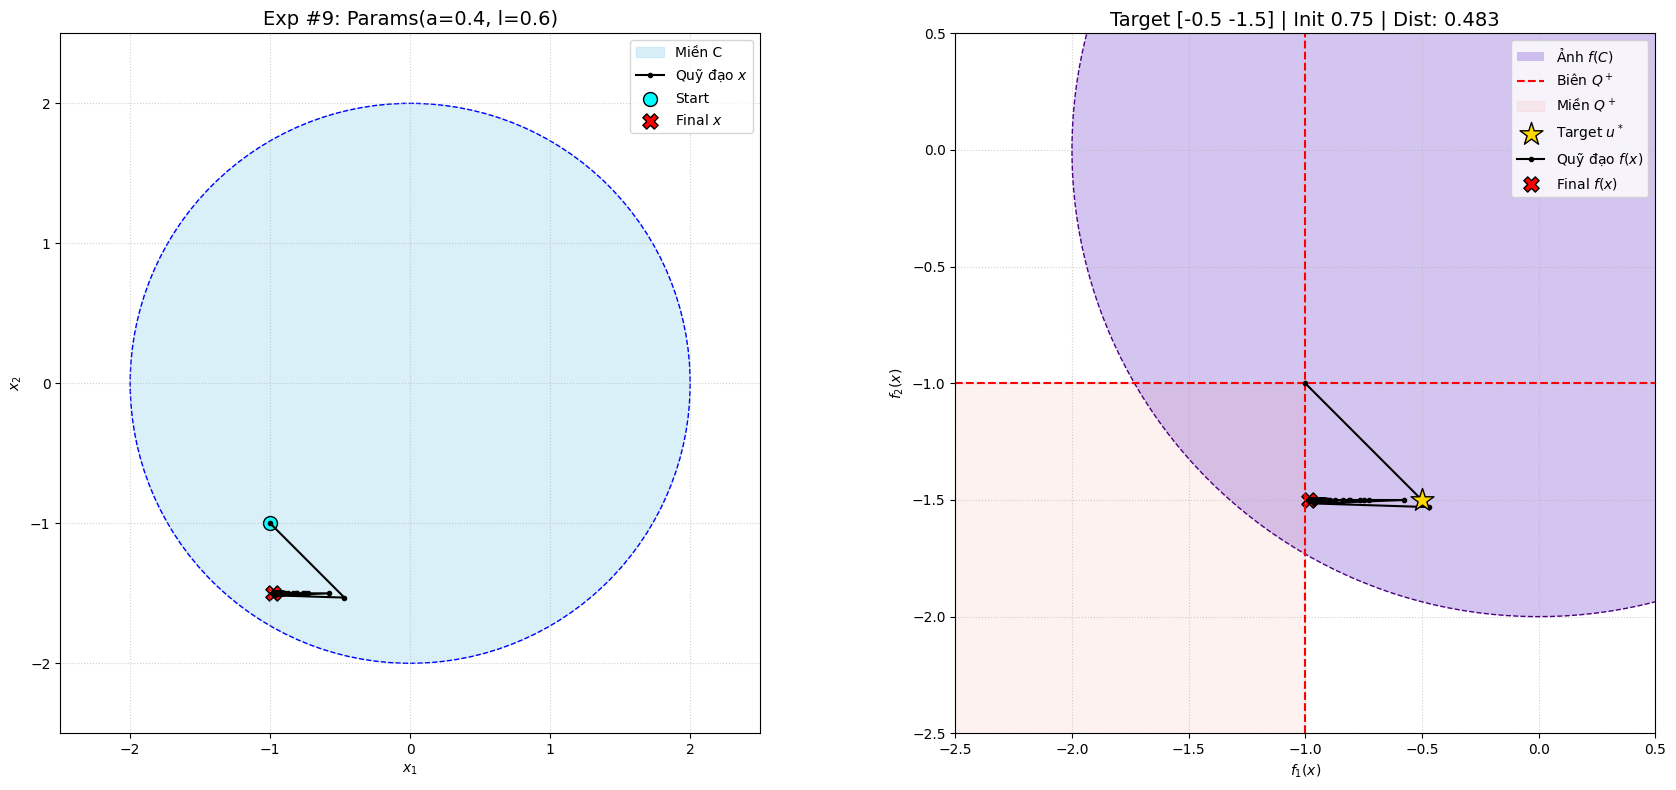


EXPERIMENT #10/24
Config: u*=[-0.5 -1.5], exp_a=0.4, exp_l=0.6, init=0.35


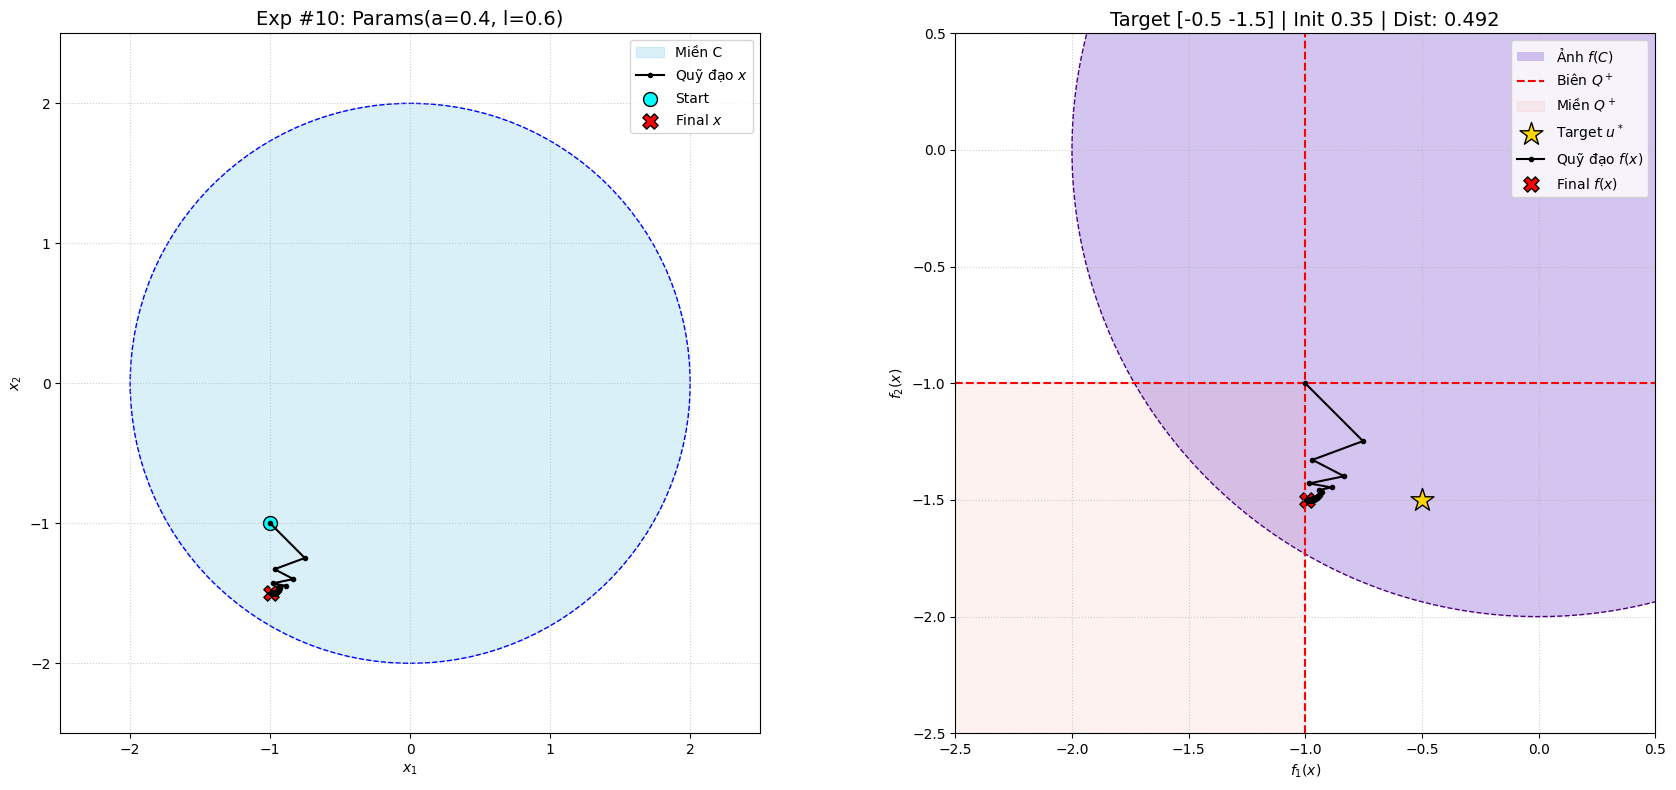


EXPERIMENT #11/24
Config: u*=[-0.5 -1.5], exp_a=0.4, exp_l=0.8, init=0.75


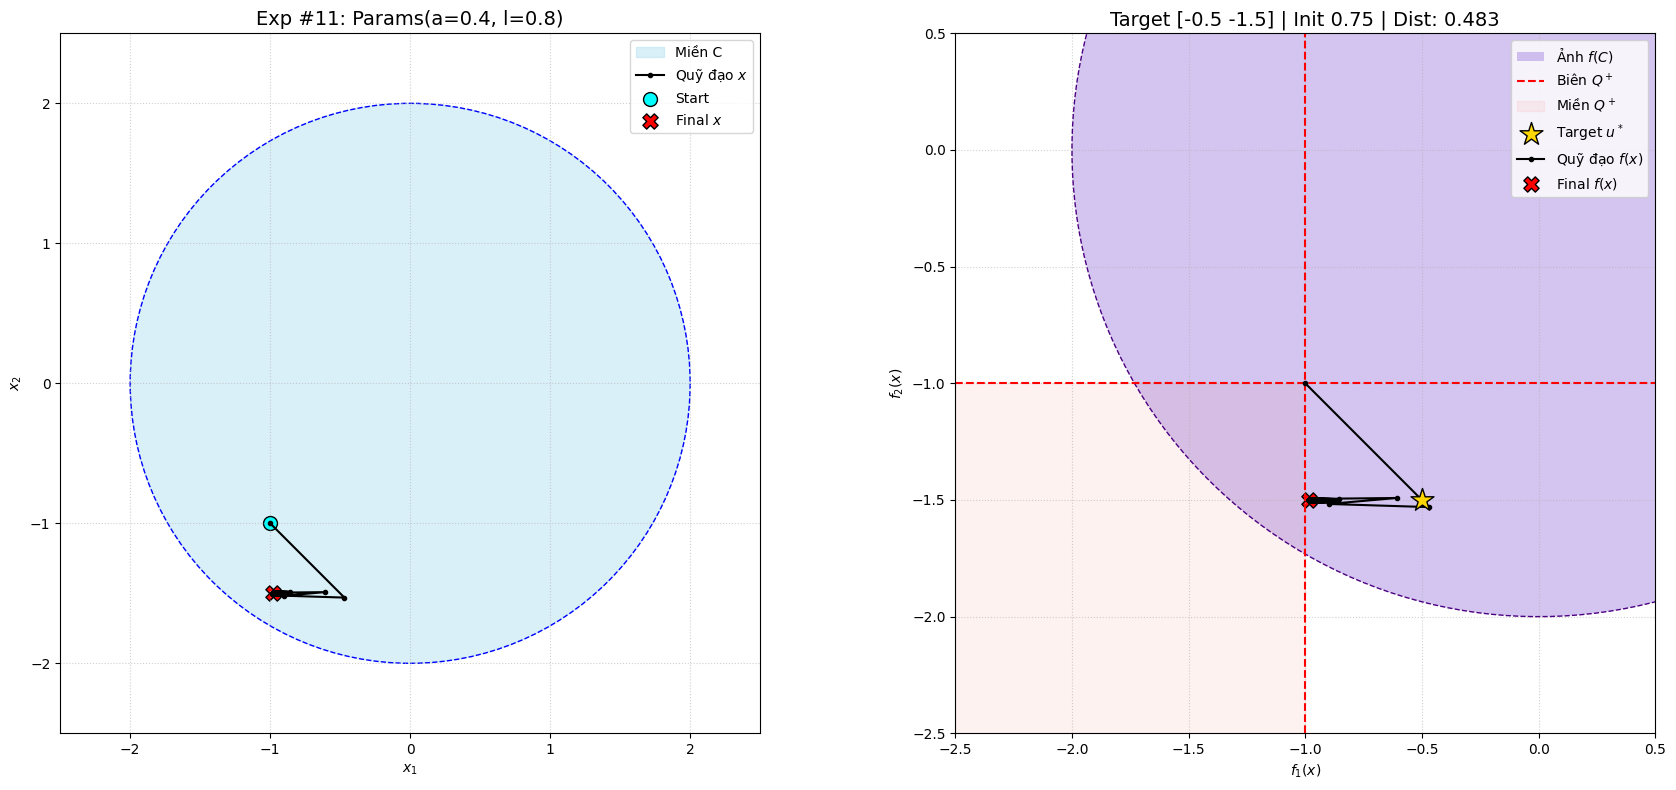


EXPERIMENT #12/24
Config: u*=[-0.5 -1.5], exp_a=0.4, exp_l=0.8, init=0.35


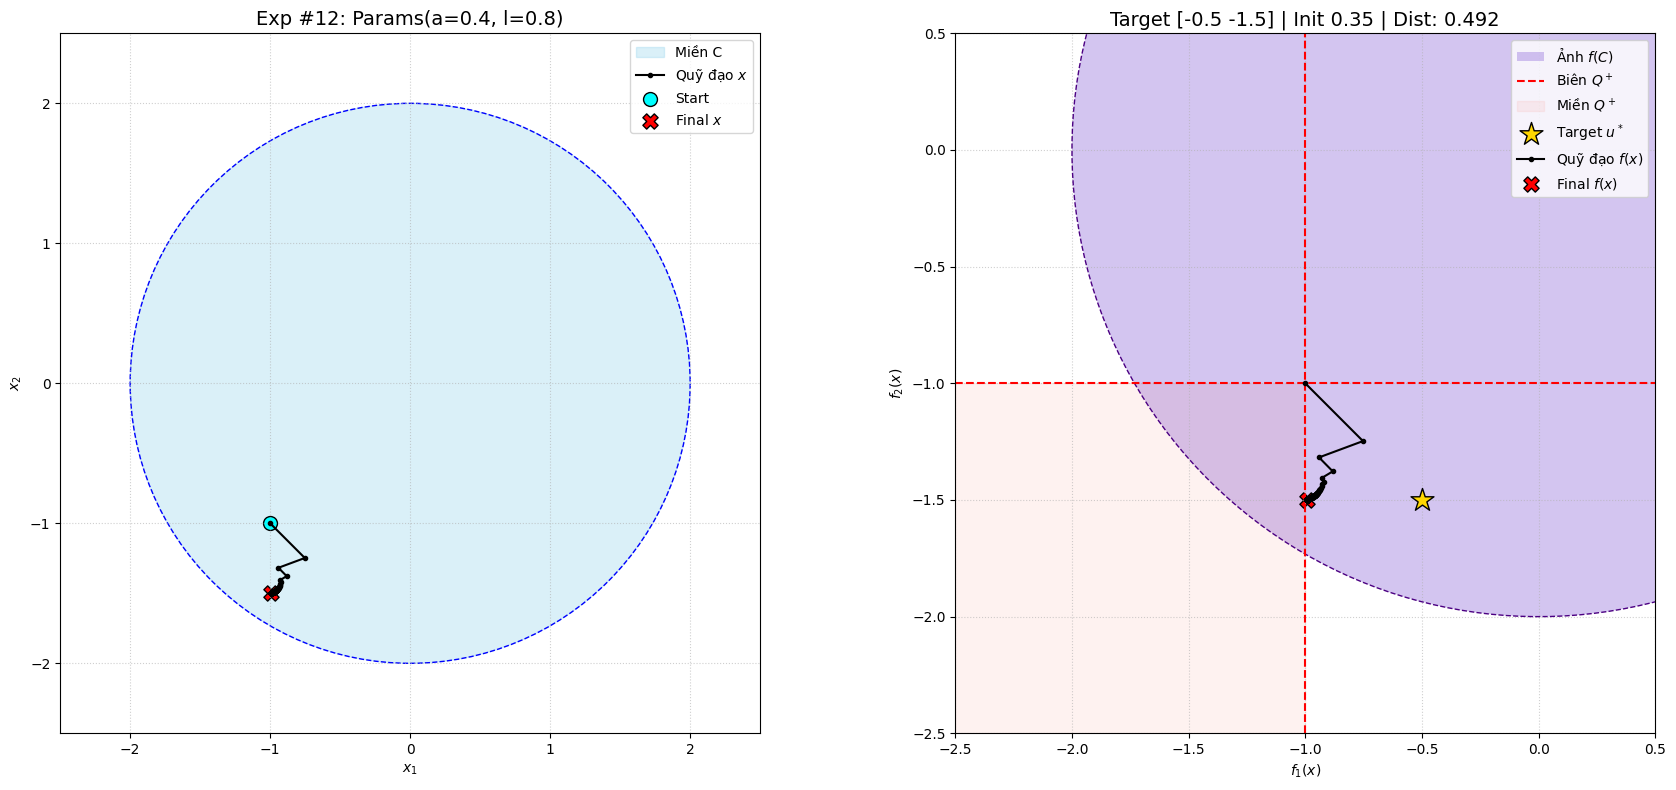


EXPERIMENT #13/24
Config: u*=[-0.5 -1.5], exp_a=0.6, exp_l=0.6, init=0.75


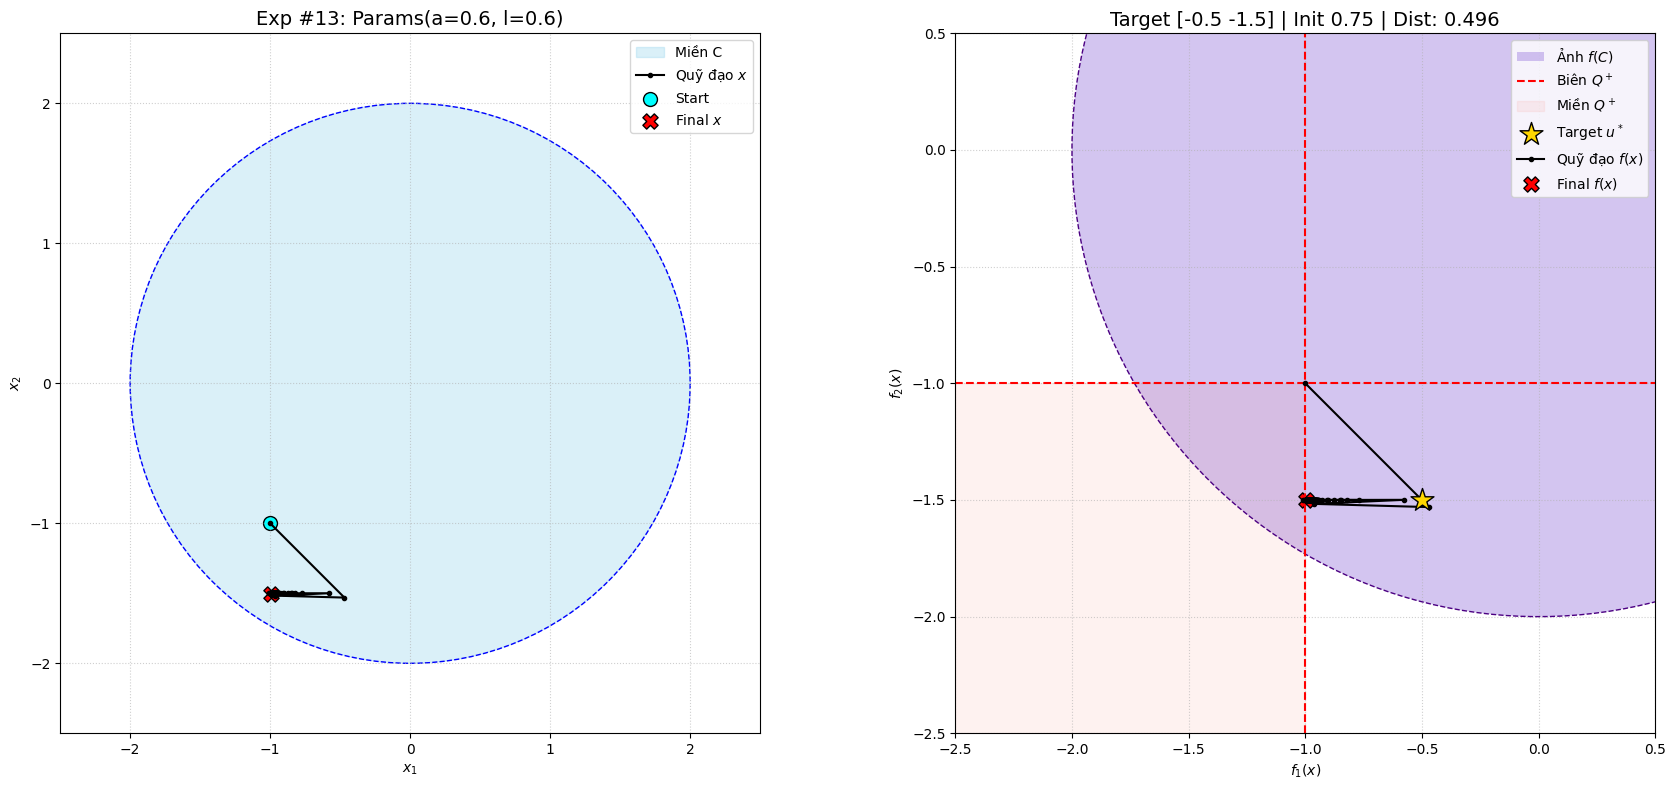


EXPERIMENT #14/24
Config: u*=[-0.5 -1.5], exp_a=0.6, exp_l=0.6, init=0.35


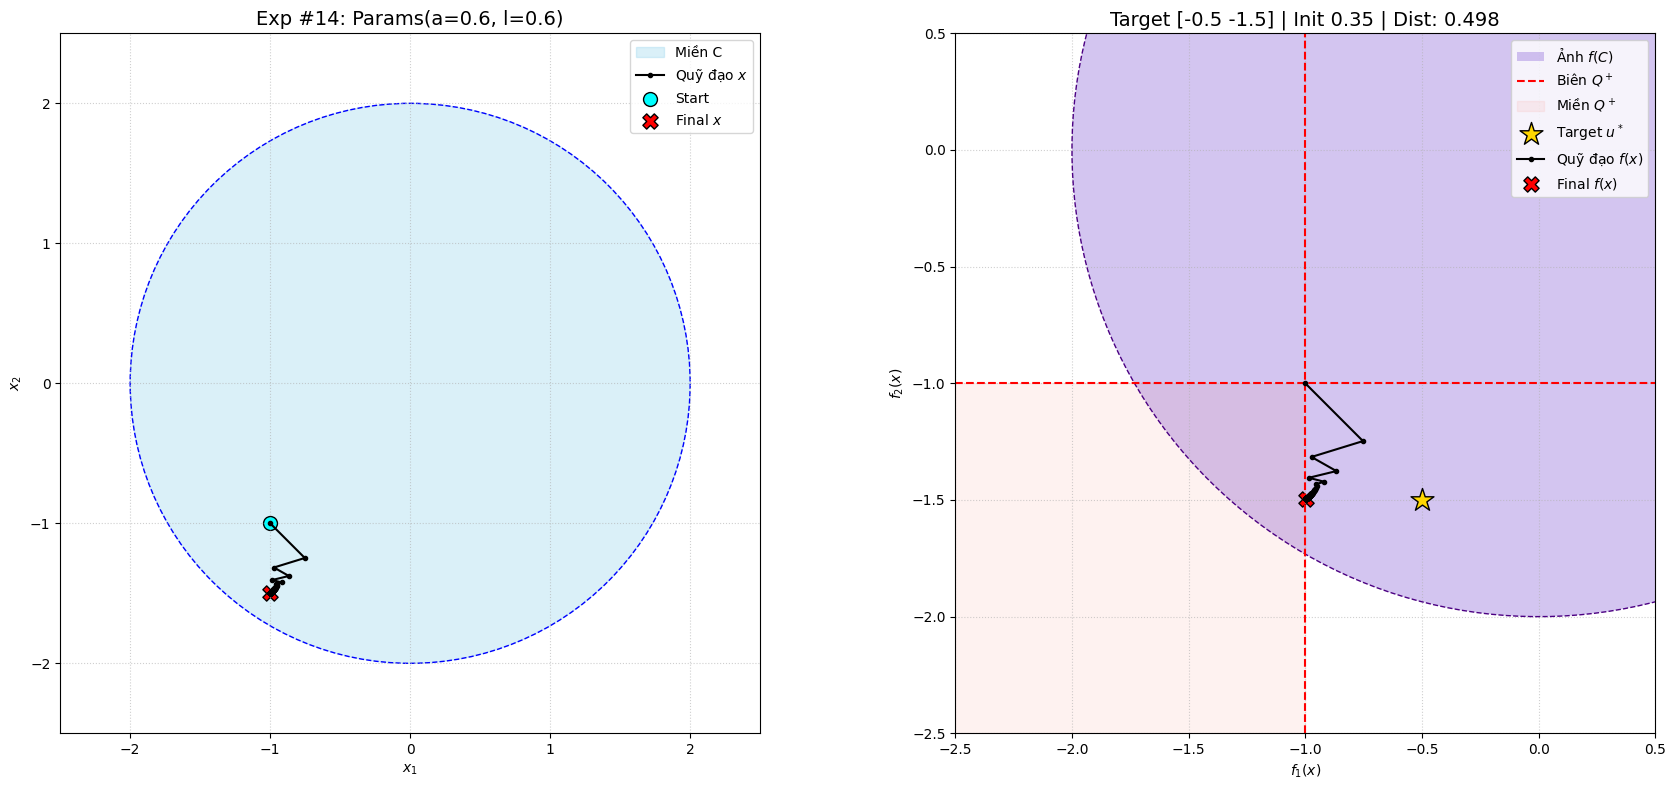


EXPERIMENT #15/24
Config: u*=[-0.5 -1.5], exp_a=0.6, exp_l=0.8, init=0.75


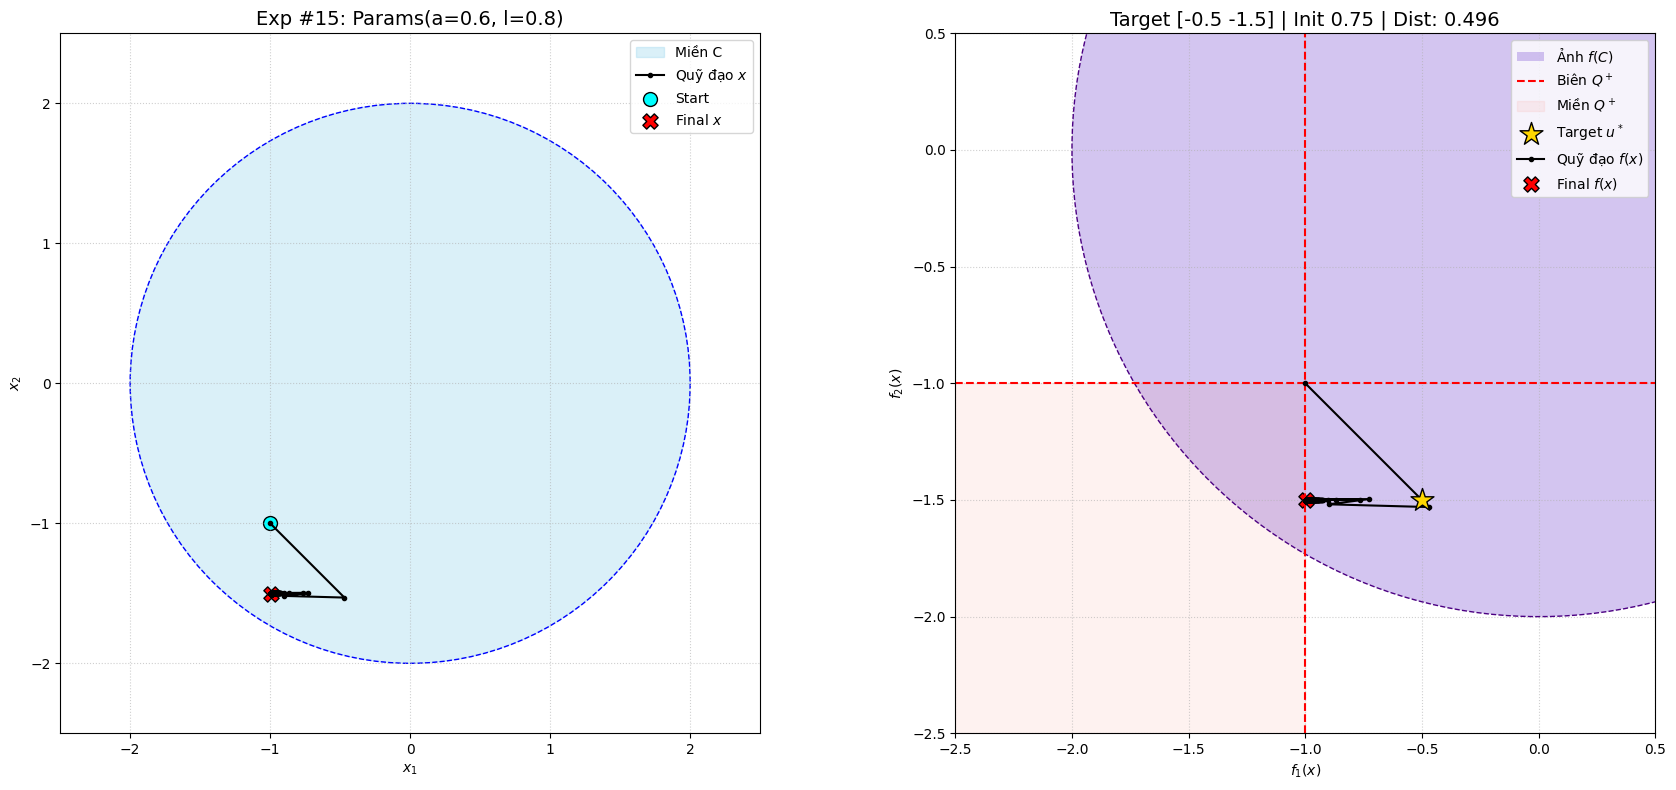


EXPERIMENT #16/24
Config: u*=[-0.5 -1.5], exp_a=0.6, exp_l=0.8, init=0.35


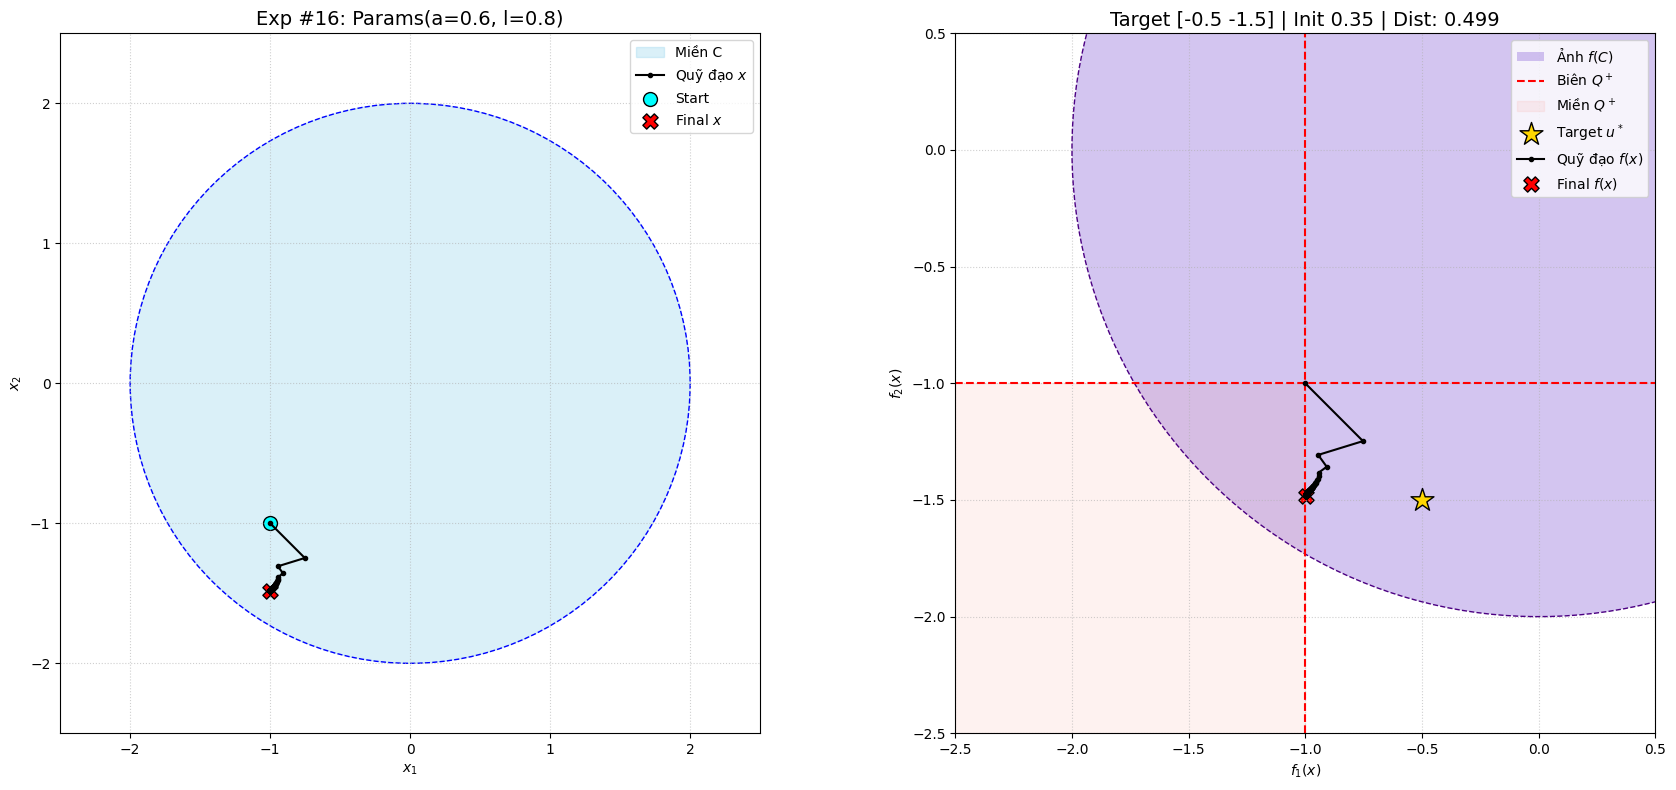


EXPERIMENT #17/24
Config: u*=[-2.5 -0.5], exp_a=0.4, exp_l=0.6, init=0.75


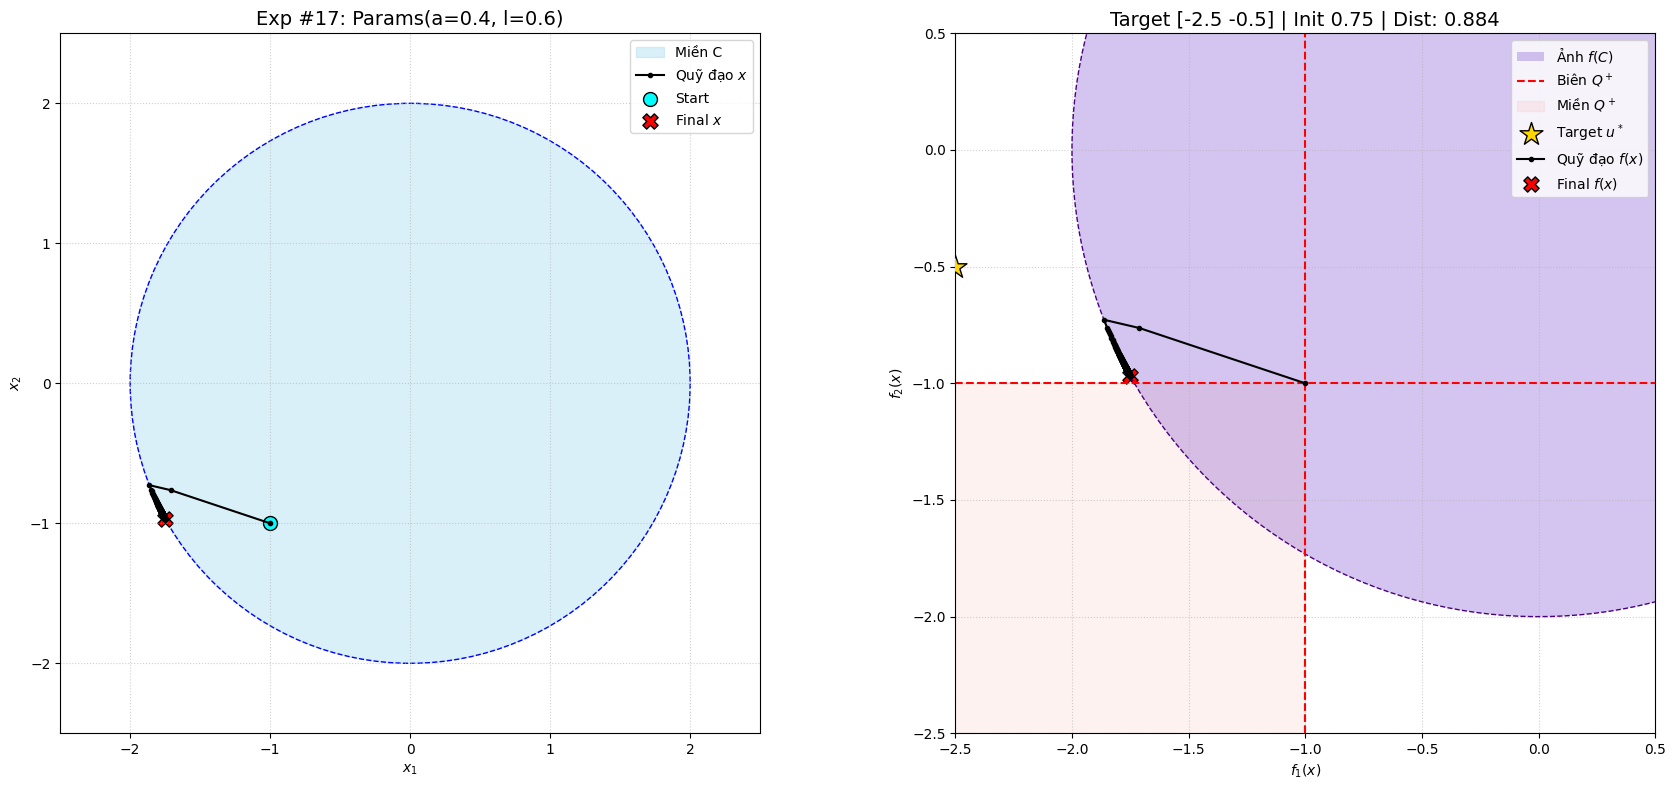


EXPERIMENT #18/24
Config: u*=[-2.5 -0.5], exp_a=0.4, exp_l=0.6, init=0.35


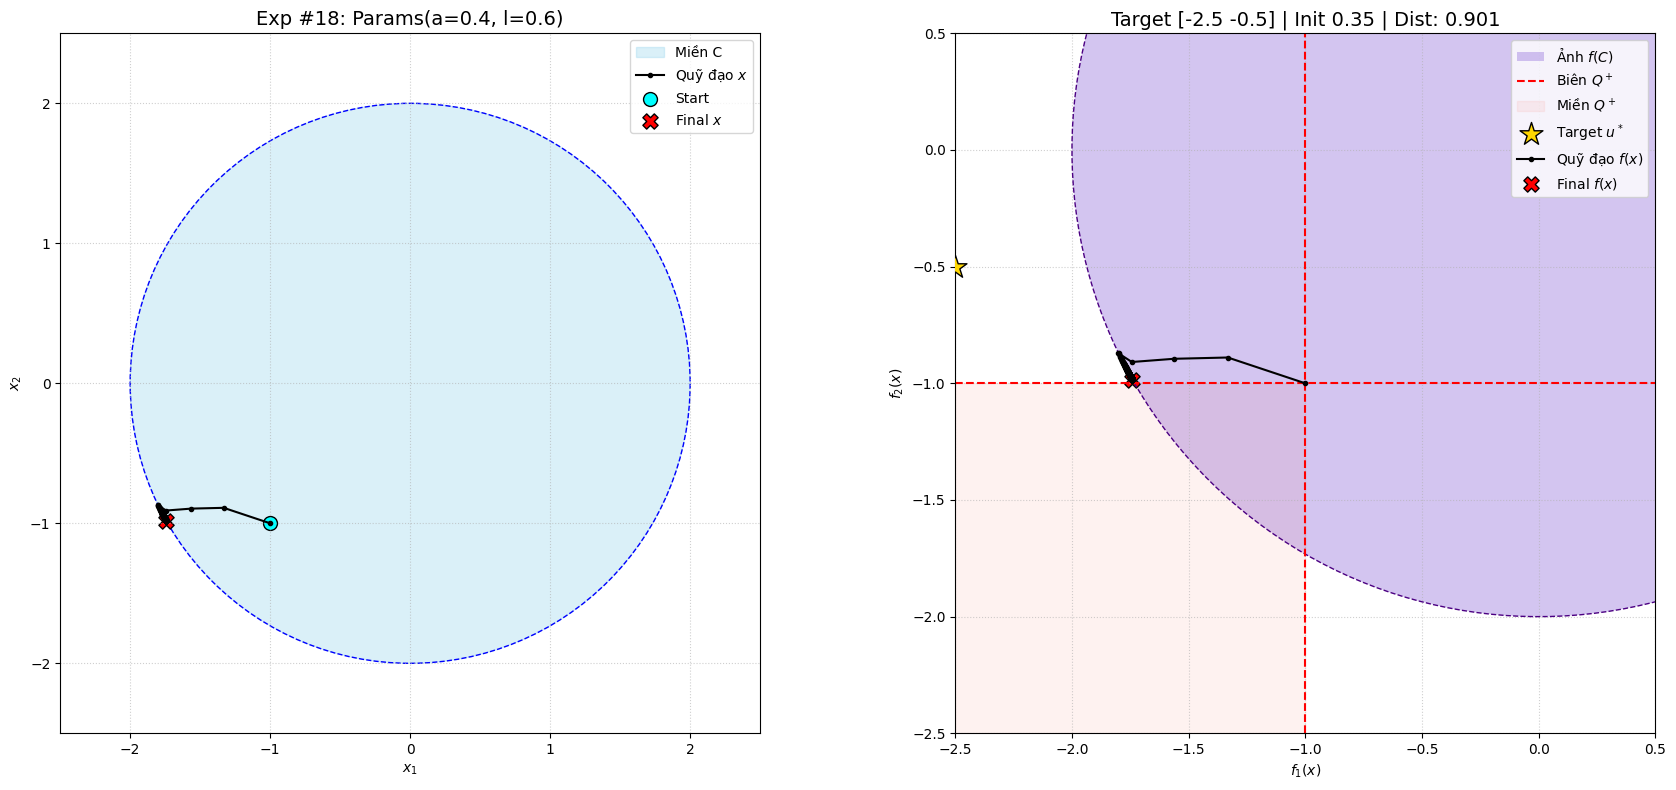


EXPERIMENT #19/24
Config: u*=[-2.5 -0.5], exp_a=0.4, exp_l=0.8, init=0.75


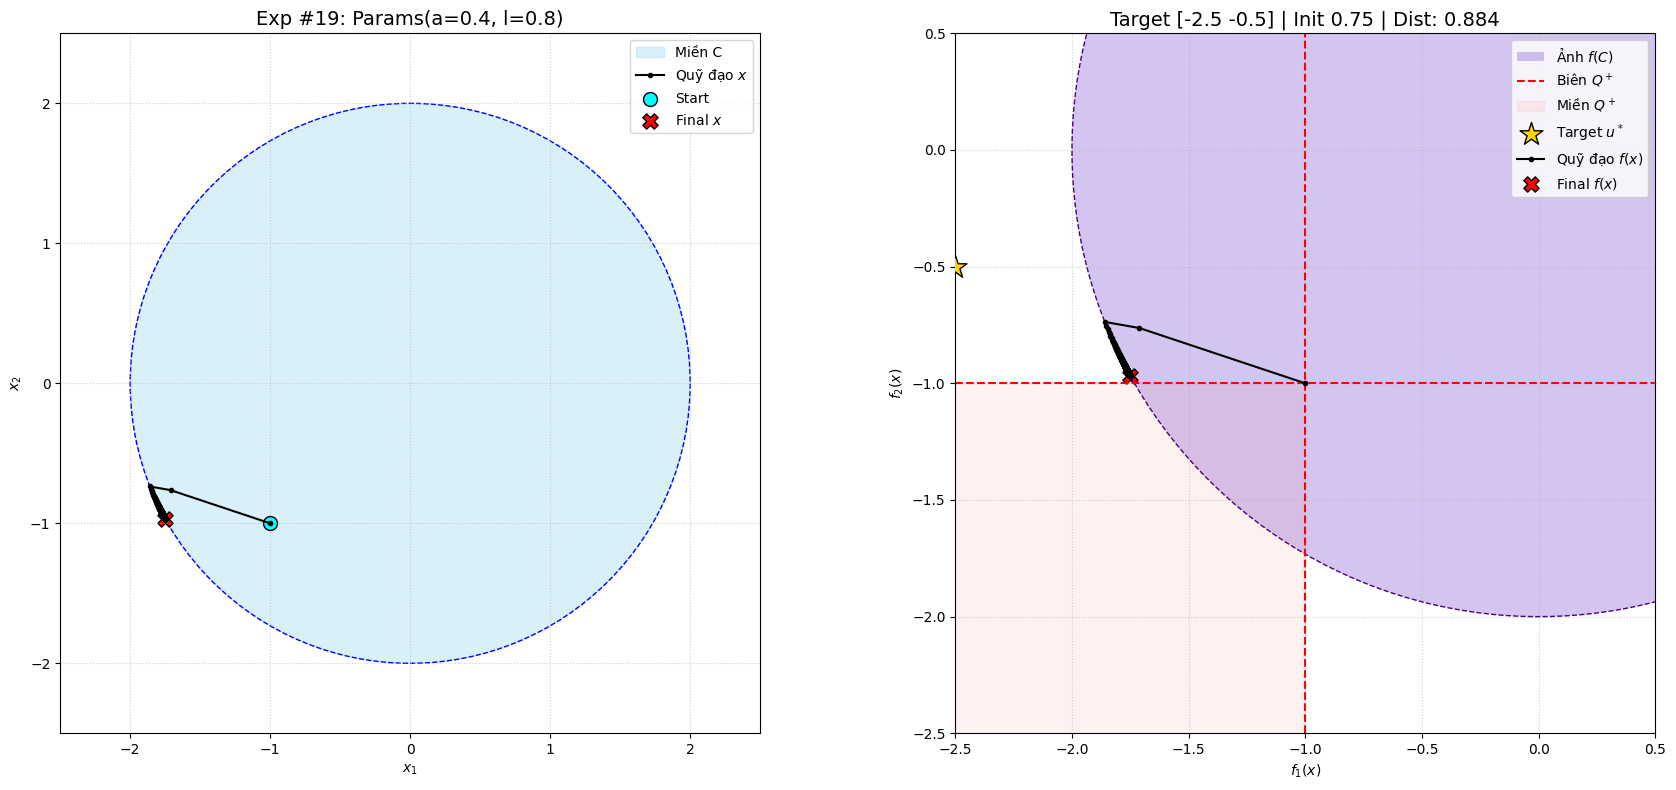


EXPERIMENT #20/24
Config: u*=[-2.5 -0.5], exp_a=0.4, exp_l=0.8, init=0.35


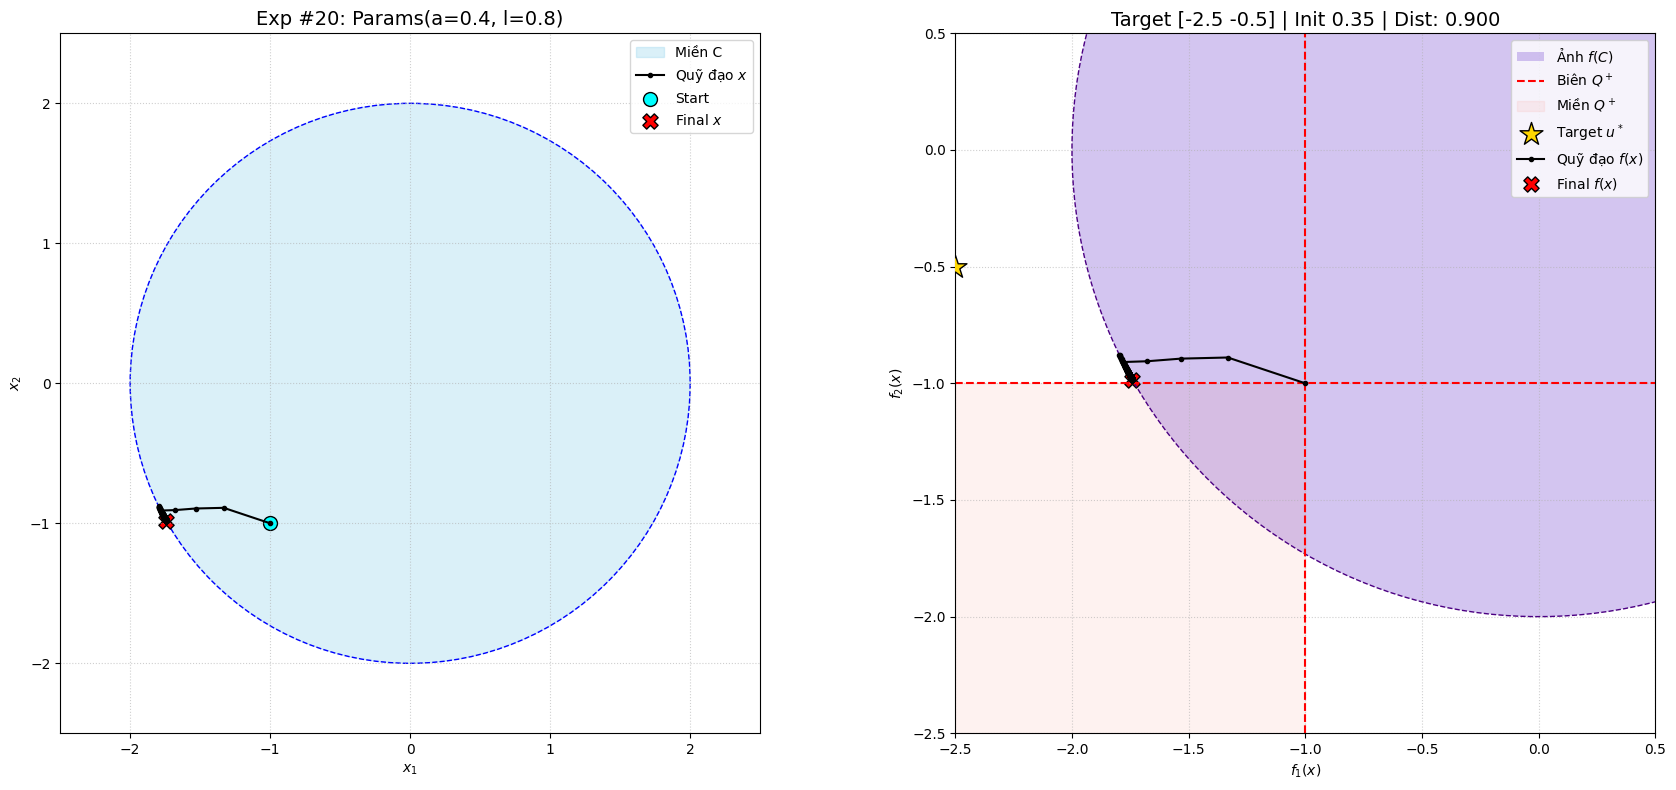


EXPERIMENT #21/24
Config: u*=[-2.5 -0.5], exp_a=0.6, exp_l=0.6, init=0.75


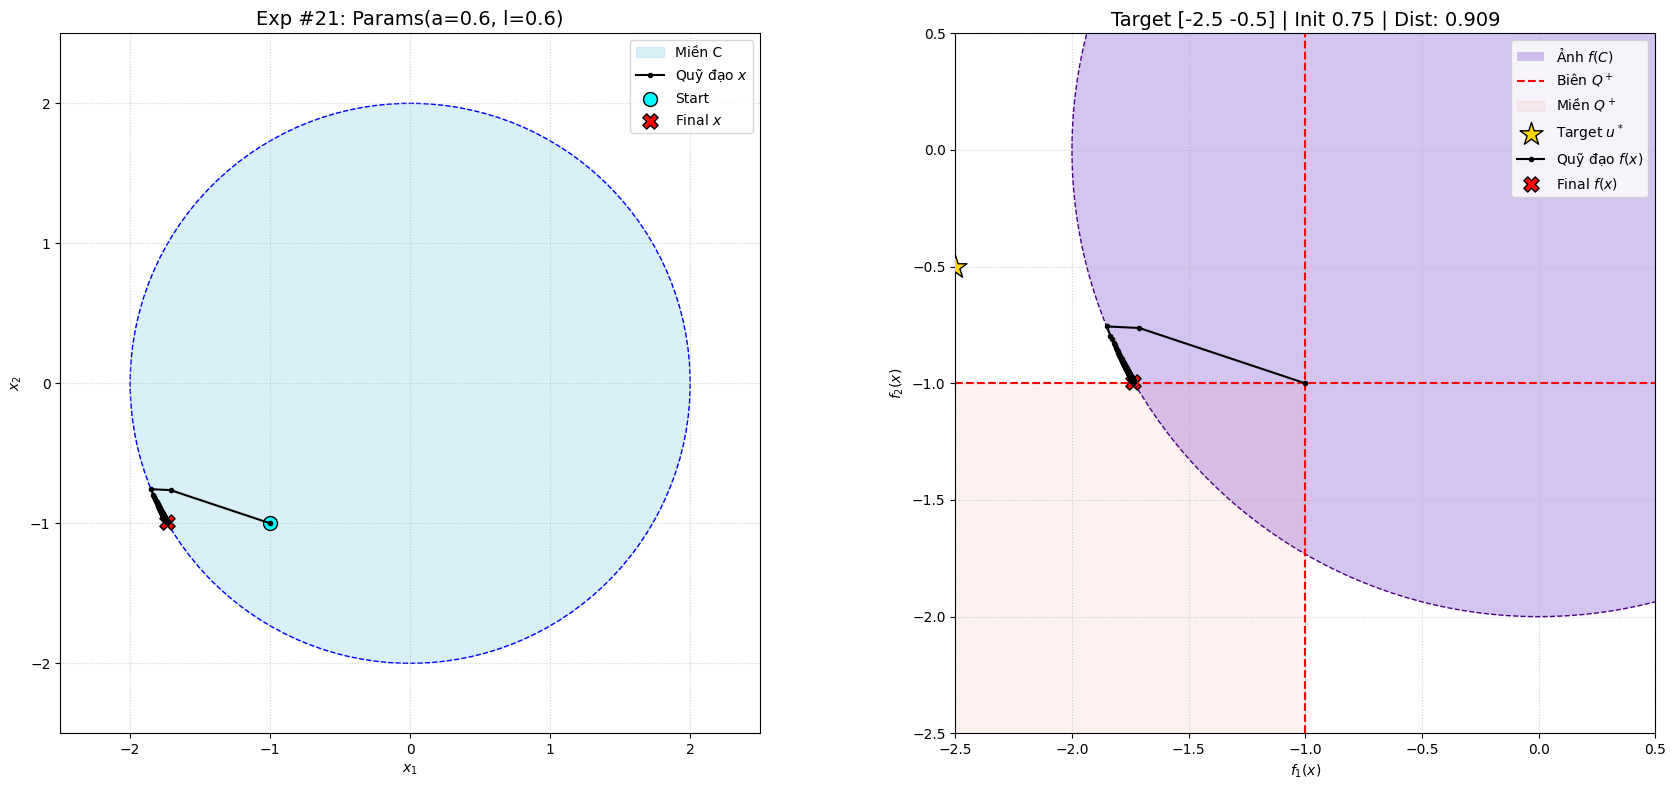


EXPERIMENT #22/24
Config: u*=[-2.5 -0.5], exp_a=0.6, exp_l=0.6, init=0.35


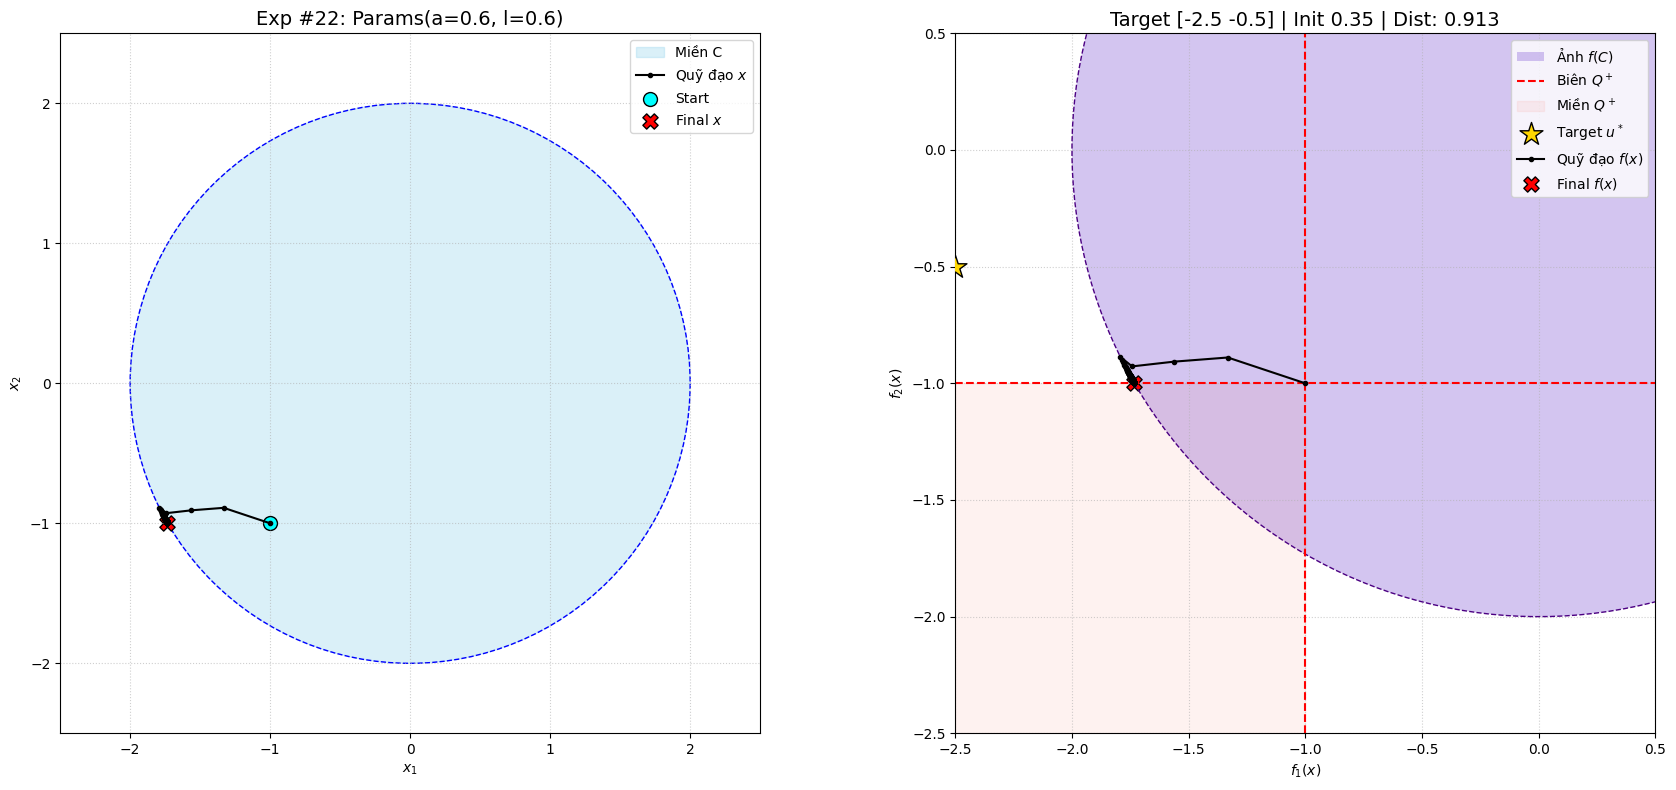


EXPERIMENT #23/24
Config: u*=[-2.5 -0.5], exp_a=0.6, exp_l=0.8, init=0.75


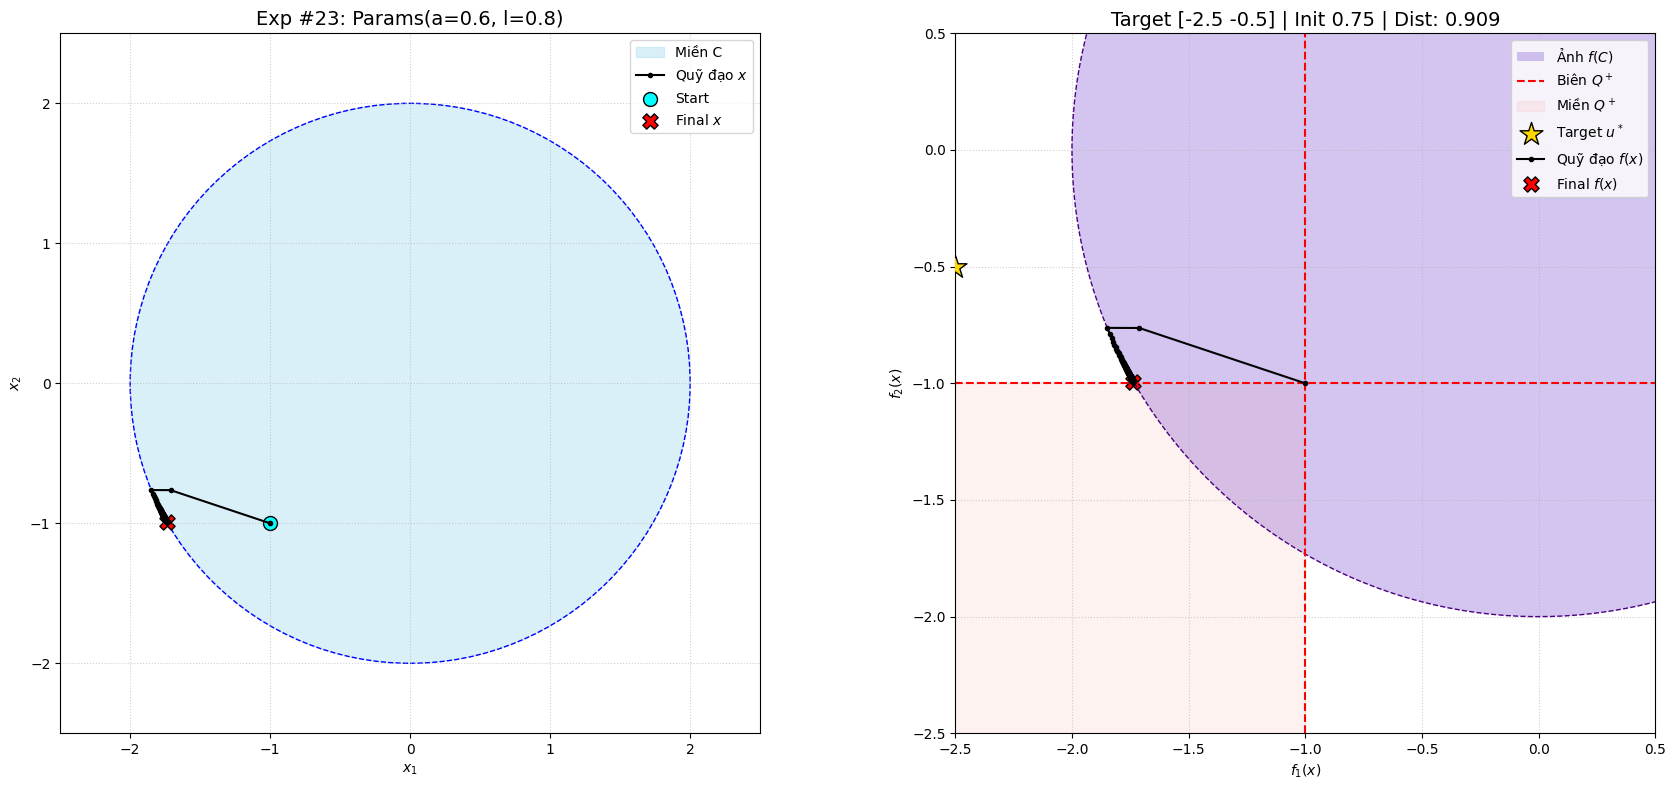


EXPERIMENT #24/24
Config: u*=[-2.5 -0.5], exp_a=0.6, exp_l=0.8, init=0.35


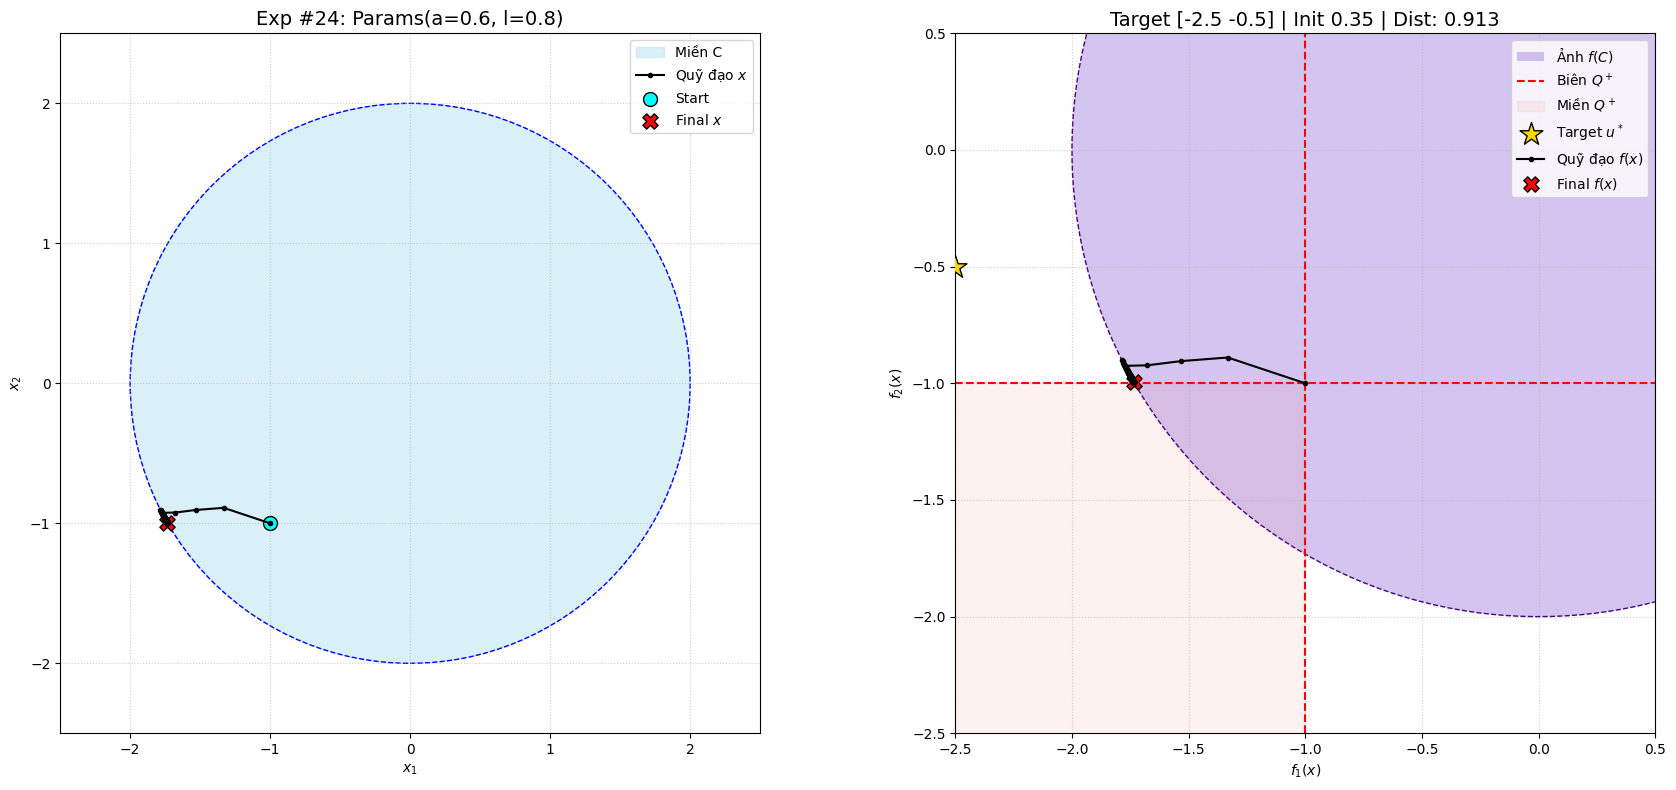



============================== KẾT QUẢ TỔNG HỢP ==============================
+----+---------------+-----------+------------+--------+---------------+---------+---------+
| ID |       u*      | Exp_Alpha | Exp_Lambda | Init_P | Final_Dist_u* | Viol_Q+ |  Viol_C |
+----+---------------+-----------+------------+--------+---------------+---------+---------+
| 1  | [-1.25 -1.25] |    0.4    |    0.6     |  0.75  |      0.0      |   0.0   |   0.0   |
| 2  | [-1.25 -1.25] |    0.4    |    0.6     |  0.35  |     1e-05     |   0.0   |   0.0   |
| 3  | [-1.25 -1.25] |    0.4    |    0.8     |  0.75  |      0.0      |   0.0   |   0.0   |
| 4  | [-1.25 -1.25] |    0.4    |    0.8     |  0.35  |     1e-05     |   0.0   |   0.0   |
| 5  | [-1.25 -1.25] |    0.6    |    0.6     |  0.75  |     4e-05     |   0.0   |   0.0   |
| 6  | [-1.25 -1.25] |    0.6    |    0.6     |  0.35  |     5e-05     |   0.0   |  9e-05  |
| 7  | [-1.25 -1.25] |    0.6    |    0.8     |  0.75  |    0.00062    |   0.0   |

In [23]:
# --- CẤU HÌNH THÍ NGHIỆM ---

# 1. Các điểm mục tiêu muốn thử
list_u_star = [
    np.array([-1.25, -1.25]),
    np.array([-0.5, -1.5]), 
    np.array([-2.5, -0.5])  
]


list_expo_alpha = [0.4, 0.6]

list_expo_lambda = [0.60, 0.8]

list_init_params = [0.75, 0.35]

# --- CHẠY ---
df_results = run_experiment_grid(
    prob=prob,
    x_feasible=x_feasible,
    list_u_star=list_u_star,
    list_expo_alpha=list_expo_alpha,
    list_expo_lambda=list_expo_lambda,
    list_init_params=list_init_params,
    max_iter=2000 
)

# Khảo sát

* liệt kê kịch bản 
* **các dãy đảm bảo hội tụ**
* sau đó mới đến các case khác, tổng quát hơn

---